In [1]:
import numpy as np
import os
import glob
from pathlib import Path
from tabulate import tabulate


def process_displacement_vector(displacement_matrix):
    """Process displacement matrix for 2D analysis (remove z-component)."""
    flattened = displacement_matrix.flatten()
    displacement_2d = flattened[np.where(np.arange(len(flattened)) % 3 != 2)]
    return displacement_2d

def analyze_matrix(matrix, name, magnitude):
    """Analyze a matrix and return results in a tabular format."""
    nonzeros = np.count_nonzero(matrix)
    density = nonzeros / matrix.size
    is_symmetric = np.allclose(matrix, matrix.T, rtol=1e-8, atol=1e-8)
    max_asymmetry = np.max(np.abs(matrix - matrix.T)) if is_symmetric else 0.0

    # Eigenvalue analysis
    try:
        eigvals = np.linalg.eigvals(matrix)
        min_eigval = np.min(np.real(eigvals))
        max_eigval = np.max(np.real(eigvals))
        is_spd_eigen = True if min_eigval > 0 else False
    except np.linalg.LinAlgError:
        min_eigval = max_eigval = np.nan
        is_spd_eigen = False

    # Cholesky decomposition for SPD check
    try:
        np.linalg.cholesky(matrix)
        is_spd_cholesky = True
    except np.linalg.LinAlgError:
        is_spd_cholesky = False

    # Prepare table row
    return [
        magnitude,
        matrix.shape,
        matrix.dtype,
        f"{matrix.nbytes / 1024:.2f} KB",
        nonzeros,
        f"{density:.2%}",
        matrix.size - nonzeros,
        is_symmetric,
        f"{max_asymmetry:.2e}",
        f"{np.min(matrix):.2e}",
        f"{np.max(matrix):.2e}",
        f"{np.mean(matrix):.2e}",
        f"{np.std(matrix):.2e}",
        f"{min_eigval:.2e}",
        f"{max_eigval:.2e}",
        is_spd_eigen,
        is_spd_cholesky,
    ]

def analyze_vector(vector, name, magnitude):
    """Analyze a vector and return results in a tabular format."""
    nonzeros = np.count_nonzero(vector)
    density = nonzeros / vector.size
    return [
        magnitude,
        vector.shape,
        vector.dtype,
        f"{vector.nbytes / 1024:.2f} KB",
        nonzeros,
        f"{density:.2%}",
        vector.size - nonzeros,
        "-", "-",  # Symmetry checks (N/A for vectors)
        f"{np.min(vector):.2e}",
        f"{np.max(vector):.2e}",
        f"{np.mean(vector):.2e}",
        f"{np.std(vector):.2e}",
        "-", "-",  # Eigenvalue analysis (N/A for vectors)
        "-", "-",  # Symmetry checks (N/A for vectors)
    ]

def extract_magnitude(filename):
    """Extract the magnitude from the filename."""
    start = filename.find('[')
    end = filename.find(']')
    if start == -1 or end == -1:
        return None
    magnitude_str = filename[start + 1:end]
    return tuple(map(float, magnitude_str.split(',')))

def load_and_analyze_components(folder, component_name, analysis_function):
    """Load and analyze components (matrices or vectors) from a folder."""
    files = sorted(glob.glob(os.path.join(folder, "*.npy")))
    table_data = []
    magnitudes = []

    if not files:
        print(f"No files found in {component_name} folder.")
        return None, None

    for file in files:
        component = np.load(file)
        magnitude = extract_magnitude(os.path.basename(file))
        magnitudes.append(magnitude)
        table_data.append(analysis_function(component, component_name, magnitude))

    headers = [
        "Magnitude", "Shape", "Data Type", "Memory Size", "Non-Zero Elements", "Density",
        "Zero Elements", "Symmetry Check", "Max Asymmetry", "Min Value", "Max Value",
        "Mean Value", "Std Dev", "Min Eig Value", "Max Eig Value", "SPD (Eigen)", "Symmetric PD"
    ]
    print(f"\nDetailed Analysis of {component_name}:")
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    return files, magnitudes

def load_and_analyze_displacement_vectors(folder):
    """Load and analyze displacement vectors, including processed data."""
    files = sorted(glob.glob(os.path.join(folder, "*.npy")))
    original_table_data = []
    processed_table_data = []
    magnitudes = []

    if not files:
        print("No files found in Displacement Vector folder.")
        return None, None

    for file in files:
        original_vector = np.load(file)
        processed_vector = process_displacement_vector(original_vector)
        magnitude = extract_magnitude(os.path.basename(file))
        magnitudes.append(magnitude)

        # Analyze both original and processed vectors
        original_table_data.append(analyze_vector(original_vector, "Original Displacement Vector", magnitude))
        processed_table_data.append(analyze_vector(processed_vector, "Processed Displacement Vector", magnitude))

    headers = [
        "Magnitude", "Shape", "Data Type", "Memory Size", "Non-Zero Elements", "Density",
        "Zero Elements", "Symmetry Check", "Max Asymmetry", "Min Value", "Max Value",
        "Mean Value", "Std Dev", "Min Eig Value", "Max Eig Value", "SPD (Eigen)", "Symmetric PD"
    ]

    # Print tables
    print("\nDetailed Analysis of Original Displacement Vectors:")
    print(tabulate(original_table_data, headers=headers, tablefmt="grid"))

    print("\nDetailed Analysis of Processed Displacement Vectors:")
    print(tabulate(processed_table_data, headers=headers, tablefmt="grid"))

    return files, magnitudes

def check_missing_files(mass_mags, stiffness_mags, disp_mags, force_mags):
    """Check for missing magnitudes across components and report."""
    all_magnitudes = set(mass_mags) & set(stiffness_mags) & set(disp_mags) & set(force_mags)
    missing = {
        "Mass Matrix": set(mass_mags) - all_magnitudes,
        "Stiffness Matrix": set(stiffness_mags) - all_magnitudes,
        "Displacement Vector": set(disp_mags) - all_magnitudes,
        "Force Vector": set(force_mags) - all_magnitudes,
    }

    print("\n=== Missing Files Report ===")
    for component, missing_mags in missing.items():
        if missing_mags:
            print(f" - Missing in {component}: {missing_mags}")
        else:
            print(f" - All magnitudes present in {component}.")

def final_compatibility_check(M, K, x, f):
    """Perform final compatibility check for dimensions."""
    print("\n" + "=" * 50)
    print("FINAL COMPATIBILITY CHECK")
    print("=" * 50)

    print(f"Mass matrix shape: {M.shape}")
    print(f"Stiffness matrix shape: {K.shape}")
    print(f"2D Displacement vector shape: {x[0].shape}")
    print(f"Force vector shape: {f[0].shape}")

    incompatible = []
    if M.shape != K.shape:
        incompatible.append("Mass and Stiffness matrices have different dimensions.")
    if M.shape[1] != x[0].shape[0]:
        incompatible.append("Matrix and displacement vector dimensions don't match.")
    if M.shape[1] != f[0].shape[0]:
        incompatible.append("Matrix and force vector dimensions don't match.")

    if incompatible:
        print("\nWARNING: Found incompatibilities:")
        for issue in incompatible:
            print(f" - {issue}")
    else:
        print("\nAll components have compatible dimensions!")
        print("\nAvailable components:")
        print(f"M: Shape {M.shape}")
        print(f"K: Shape {K.shape}")
        print(f"x_original: {len(x)} vectors")
        print(f"x: {x[0].shape} (Processed)")
        print(f"f: {len(f)} vectors")
        print("is_compatible: True")
        print("loaded_successfully: True")
        print("compatibility_checked: True")

def load_structural_matrices():
    """Load and analyze all structural matrices and vectors."""
    current_path = os.getcwd()
    kratos_results_path = os.path.join(current_path, "Kratos_Results")

    print("\n" + "=" * 50)
    print("LOADING MASS MATRIX")
    print("=" * 50)
    mass_folder = os.path.join(kratos_results_path, "mass_results")
    M_files, mass_magnitudes = load_and_analyze_components(mass_folder, "Mass Matrix", analyze_matrix)

    print("\n" + "=" * 50)
    print("LOADING STIFFNESS MATRIX")
    print("=" * 50)
    stiffness_folder = os.path.join(kratos_results_path, "stiffness_results")
    K_files, stiffness_magnitudes = load_and_analyze_components(stiffness_folder, "Stiffness Matrix", analyze_matrix)

    print("\n" + "=" * 50)
    print("LOADING DISPLACEMENT VECTOR")
    print("=" * 50)
    displacement_folder = os.path.join(kratos_results_path, "displacement_results")
    x_files, disp_magnitudes = load_and_analyze_displacement_vectors(displacement_folder)

    print("\n" + "=" * 50)
    print("LOADING FORCE VECTOR")
    print("=" * 50)
    force_folder = os.path.join(kratos_results_path, "loading_results")
    f_files, force_magnitudes = load_and_analyze_components(force_folder, "Force Vector", analyze_vector)

    # Check if all magnitudes are identical
    if (
        mass_magnitudes == stiffness_magnitudes == disp_magnitudes == force_magnitudes
    ):
        magnitudes = mass_magnitudes  # Use any of the lists as they are identical
        print("\nAll magnitudes are identical and saved under 'magnitudes'.")
    else:
        print("\nWarning: Magnitudes are not identical across components.")
        print(f"Mass Magnitudes: {mass_magnitudes}")
        print(f"Stiffness Magnitudes: {stiffness_magnitudes}")
        print(f"Displacement Magnitudes: {disp_magnitudes}")
        print(f"Force Magnitudes: {force_magnitudes}")
        magnitudes = None

    # Perform compatibility check if all components are loaded
    if M_files and K_files and x_files and f_files:
        # Load matrices
        M = np.load(M_files[0])
        K = np.load(K_files[0])

        # Load displacement and force vectors as 2D arrays (612 rows, columns = number of files)
        x_original = np.column_stack([np.load(file) for file in x_files])
        x = np.column_stack([process_displacement_vector(np.load(file)) for file in x_files])
        f = np.column_stack([np.load(file) for file in f_files])

        final_compatibility_check(M, K, x, f)
        print("\nMatrices successfully loaded and compatibility checked!")

        return M, K, x_original, x, f, magnitudes
    else:
        print("Error: One or more required components are missing.")
        return None, None, None, None, None, None


def final_compatibility_check(M, K, x, f):
    """Perform final compatibility check for dimensions."""
    print("\n" + "=" * 50)
    print("FINAL COMPATIBILITY CHECK")
    print("=" * 50)

    print(f"Mass matrix shape: {M.shape}")
    print(f"Stiffness matrix shape: {K.shape}")
    print(f"2D Displacement vector shape: {x.shape}")
    print(f"Force vector shape: {f.shape}")

    incompatible = []

    # Ensure matrix row sizes match vector row sizes
    if M.shape[0] != x.shape[0]:
        incompatible.append("Mass matrix row count and displacement vector row count don't match.")
    if M.shape[0] != f.shape[0]:
        incompatible.append("Mass matrix row count and force vector row count don't match.")
    if K.shape != M.shape:
        incompatible.append("Mass matrix and stiffness matrix dimensions don't match.")

    # Display compatibility results
    if incompatible:
        print("\nWARNING: Found incompatibilities:")
        for issue in incompatible:
            print(f" - {issue}")
    else:
        print("\nAll components have compatible dimensions!")

    # Summary of components
    print("\nAvailable components:")
    print(f"M: Shape {M.shape}")
    print(f"K: Shape {K.shape}")
    print(f"x_original: Shape {x.shape}")
    print(f"x: Shape {x.shape} (Processed)")
    print(f"f: Shape {f.shape}")
    print("is_compatible:", not incompatible)
    print("loaded_successfully: True")
    print("compatibility_checked: True")


# Run the function
M, K, x_original, x, f, magnitudes = load_structural_matrices()


LOADING MASS MATRIX

Detailed Analysis of Mass Matrix:
+---------------------------+------------+-------------+---------------+---------------------+-----------+-----------------+------------------+-----------------+-------------+-------------+--------------+-----------+-----------------+-----------------+---------------+----------------+
| Magnitude                 | Shape      | Data Type   | Memory Size   |   Non-Zero Elements | Density   |   Zero Elements | Symmetry Check   |   Max Asymmetry |   Min Value |   Max Value |   Mean Value |   Std Dev |   Min Eig Value |   Max Eig Value | SPD (Eigen)   | Symmetric PD   |
+===========================+============+=============+===============+=====================+===========+=================+==================+=================+=============+=============+==============+===========+=================+=================+===============+================+
| (-137.59, -63.13, 362.93) | (612, 612) | float64     | 2926.12 KB    |              

In [2]:
# Check if matrices are already loaded
if 'M' in globals() and 'K' in globals() and 'x' in globals() and 'f' in globals():
    print("Matrices are already loaded and ready for boundary condition application.")
else:
    print("Error: Matrices are not loaded. Please run `load_structural_matrices()` first.")


Matrices are already loaded and ready for boundary condition application.


In [3]:
def apply_boundary_conditions_multiple_components_with_nodes(M, K, f, magnitudes):
    """
    Apply boundary conditions to the Mass matrix, Stiffness matrix, and Force vectors
    for multiple cases. Provides a tabulated summary of the constrained DOFs and Nodes for each file.
    """
    try:
        # Locate .mdpa file
        base_path = Path.cwd()
        mdpa_file = next(base_path.glob('*.mdpa'), None)
        if not mdpa_file:
            raise FileNotFoundError("No .mdpa file found in the current directory.")
        print(f"Using .mdpa file: {mdpa_file.name}")

        # Parse .mdpa file to identify fixed nodes
        nodes = {}
        fixed_nodes = set()
        with open(mdpa_file, 'r') as file:
            lines = file.readlines()

        reading_nodes = False
        reading_fixed = False

        for line in lines:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif "Begin SubModelPart DISPLACEMENT_fixed" in line or "Begin SubModelPart DISPLACEMENT_Fixed" in line:
                reading_fixed = True
                continue
            elif "End SubModelPart" in line:
                reading_fixed = False
                continue

            if reading_nodes:
                parts = line.split()
                if len(parts) >= 4:
                    node_id = int(parts[0])
                    x_coord, y_coord, z_coord = map(float, parts[1:4])
                    nodes[node_id] = (x_coord, y_coord, z_coord)

            if reading_fixed:
                try:
                    node_id = int(line)
                    print(f"Found fixed node: {node_id}")
                    fixed_nodes.add(node_id)
                except ValueError:
                    pass

        # Apply penalty method for boundary conditions
        penalty_factor = 1e12
        max_stiffness = np.max(np.abs(K))
        penalty = penalty_factor * max_stiffness

        print("\nApplying boundary conditions to Mass, Stiffness, and Force for multiple cases...")
        summary_data = []
        headers = ["File Index", "Magnitude", "Node Numbers", "Constrained DOFs (Applied Nodes)"]

        # Initialize constrained matrices
        M_constrained = np.copy(M)
        K_constrained = np.copy(K)
        f_constrained = np.copy(f)

        for file_index in range(f.shape[1]):  # Loop through each case
            applied_dofs = []
            applied_nodes = []
            for node_id in fixed_nodes:
                x_dof = (node_id - 1) * 2
                y_dof = x_dof + 1

                # Apply penalties to M, K, and f for this file
                M_constrained[x_dof, x_dof] = penalty
                M_constrained[y_dof, y_dof] = penalty
                K_constrained[x_dof, x_dof] = penalty
                K_constrained[y_dof, y_dof] = penalty
                f_constrained[x_dof, file_index] = 0.0
                f_constrained[y_dof, file_index] = 0.0

                applied_dofs.append(f"{x_dof} (X), {y_dof} (Y)")
                applied_nodes.append(node_id)

            # Append to summary table
            summary_data.append(
                [file_index + 1, magnitudes[file_index], ", ".join(map(str, applied_nodes)), ", ".join(applied_dofs)]
            )

        # Print summary table
        print("\nBoundary Condition Application Summary for Mass, Stiffness, and Force:")
        print(tabulate(summary_data, headers=headers, tablefmt="grid"))

        print("\nBoundary conditions applied successfully!")
        print(f"Number of constrained DOFs: {len(fixed_nodes) * 2}")

        return M_constrained, K_constrained, f_constrained, fixed_nodes

    except Exception as e:
        print(f"Error applying boundary conditions: {e}")
        return None, None, None, None


# Main Execution
try:
    # Ensure matrices and vectors are loaded
    if 'M' in globals() and 'K' in globals() and 'f' in globals() and 'magnitudes' in globals():
        print("Matrices are already loaded and ready for boundary condition application.")
    else:
        print("Error: Matrices are not loaded. Please load them using the proper function.")

    # Apply boundary conditions
    print("\nApplying boundary conditions for Mass, Stiffness, and Force across multiple cases...")
    M_constrained, K_constrained, f_constrained, fixed_nodes = apply_boundary_conditions_multiple_components_with_nodes(M, K, f, magnitudes)

    if M_constrained is not None:
        print("\nVerification of constrained system:")
        print(f"Original Mass Matrix Shape: {M.shape}")
        print(f"Constrained Mass Matrix Shape: {M_constrained.shape}")
        print(f"Original Stiffness Matrix Shape: {K.shape}")
        print(f"Constrained Stiffness Matrix Shape: {K_constrained.shape}")
        print(f"Original Force Vector Shape: {f.shape}")
        print(f"Constrained Force Vector Shape: {f_constrained.shape}")
        print(f"Number of constrained DOFs: {len(fixed_nodes) * 2}")
    else:
        print("Boundary conditions could not be applied.")
except Exception as e:
    print(f"Error during boundary condition application: {str(e)}")


Matrices are already loaded and ready for boundary condition application.

Applying boundary conditions for Mass, Stiffness, and Force across multiple cases...
Using .mdpa file: 2D_beam_udl_loading.mdpa
Found fixed node: 1
Found fixed node: 2
Found fixed node: 6
Found fixed node: 10
Found fixed node: 17
Found fixed node: 25

Applying boundary conditions to Mass, Stiffness, and Force for multiple cases...

Boundary Condition Application Summary for Mass, Stiffness, and Force:
+--------------+---------------------------+---------------------+--------------------------------------------------------------------------------------------+
|   File Index | Magnitude                 | Node Numbers        | Constrained DOFs (Applied Nodes)                                                           |
+==============+===========================+=====================+============================================================================================+
|            1 | (-137.59, -63.13, 362.9

In [4]:
def compare_force_vectors_multiple(f_list, f_constrained_list, magnitudes):
    """
    Compare multiple sets of original and constrained force vectors.
    Display differences in a tabular format with magnitude headings.
    """
    # Ensure inputs are NumPy arrays and have correct dimensions
    if not isinstance(f_list, np.ndarray) or not isinstance(f_constrained_list, np.ndarray):
        raise ValueError("f_list and f_constrained_list must be NumPy arrays.")

    # Check the shapes of the input arrays
    if f_list.shape != f_constrained_list.shape:
        raise ValueError("f_list and f_constrained_list must have the same shape.")
    if f_list.shape[1] != len(magnitudes):
        raise ValueError("The number of magnitudes does not match the number of force vector files.")

    # Prepare summary table
    summary_data = []
    headers = ["File Index", "Magnitude", "Total DOFs", "Non-Zero DOFs (Original)", "Non-Zero DOFs (Constrained)", "Differences Found"]

    # Iterate over each file (column)
    for i, magnitude in enumerate(magnitudes):
        f = f_list[:, i]
        f_constrained = f_constrained_list[:, i]

        # Check if the force vectors are identical within a tolerance
        are_equal = np.allclose(f, f_constrained, rtol=1e-10)

        # Compute differences
        diff = np.abs(f - f_constrained)
        different_dofs = np.where(diff > 1e-10)[0]  # Identify DOFs with significant differences
        num_diff_dofs = len(different_dofs)

        # Count non-zero elements
        non_zero_original = np.count_nonzero(f)
        non_zero_constrained = np.count_nonzero(f_constrained)

        # Append results to the summary table
        summary_data.append([
            i + 1,
            magnitude,
            f.shape[0],
            non_zero_original,
            non_zero_constrained,
            num_diff_dofs,
        ])

    # Print summary table
    print("\nForce Vector Comparison Summary:")
    print(tabulate(summary_data, headers=headers, tablefmt="grid"))

    # Detailed differences for each file
    for i, magnitude in enumerate(magnitudes):
        f = f_list[:, i]
        f_constrained = f_constrained_list[:, i]

        # Compute differences
        diff = np.abs(f - f_constrained)
        different_dofs = np.where(diff > 1e-10)[0]  # Identify DOFs with significant differences

        if len(different_dofs) > 0:
            print(f"\nDetailed Differences for File {i + 1} (Magnitude: {magnitude}):")
            headers = ["DOF", "Node", "Original Value", "Constrained Value", "Difference"]
            table_data = []

            for dof in different_dofs:
                # Determine the corresponding node and DOF (assuming 2 DOFs per node)
                node = dof // 2 + 1
                dof_label = "X" if dof % 2 == 0 else "Y"
                table_data.append([dof_label, node, f[dof], f_constrained[dof], diff[dof]])

            print(tabulate(table_data, headers=headers, tablefmt="grid"))
        else:
            print(f"\nNo significant differences found for File {i + 1} (Magnitude: {magnitude}).")

# Example usage
try:
    print("\nComparing force vectors for multiple files...")
    # Assuming `f` is a NumPy array of shape (DOFs, Files)
    # `f_constrained` is a NumPy array of shape (DOFs, Files)
    # `magnitudes` is a list of magnitudes corresponding to the force vector files
    compare_force_vectors_multiple(f, f_constrained, magnitudes)
except Exception as e:
    print(f"Error during force vector comparison: {str(e)}")



Comparing force vectors for multiple files...

Force Vector Comparison Summary:
+--------------+---------------------------+--------------+----------------------------+-------------------------------+---------------------+
|   File Index | Magnitude                 |   Total DOFs |   Non-Zero DOFs (Original) |   Non-Zero DOFs (Constrained) |   Differences Found |
+==============+===========================+==============+============================+===============================+=====================+
|            1 | (-137.59, -63.13, 362.93) |          612 |                        611 |                           599 |                  12 |
+--------------+---------------------------+--------------+----------------------------+-------------------------------+---------------------+
|            2 | (-198.79, 228.5, -134.8)  |          612 |                        612 |                           600 |                  12 |
+--------------+---------------------------+--------------+--

In [5]:
def check_bc_applied_to_force(f_constrained, magnitudes, threshold=1e-7):
    """
    Check whether boundary conditions (BC) have been applied to the constrained force vectors.
    Display results in a tabular format with magnitude headings.
    """
    # Convert 2D `f_constrained` to a list of vectors if necessary
    if isinstance(f_constrained, np.ndarray) and len(f_constrained.shape) == 2:
        print("Converting 2D array `f_constrained` to a list of vectors.")
        f_constrained = [f_constrained[:, i] for i in range(f_constrained.shape[1])]

    # Ensure lengths match
    if len(f_constrained) != len(magnitudes):
        print(f"Error: The number of constrained force vectors ({len(f_constrained)}) "
              f"does not match the number of magnitudes ({len(magnitudes)}).")
        return

    # Prepare table headers
    headers = ["File Index", "Magnitude", "DOF", "Node", "Direction", "Value"]
    summary_data = []

    for file_idx, (f_cons, magnitude) in enumerate(zip(f_constrained, magnitudes)):
        # Find non-zero DOFs
        non_zero_indices = np.where(abs(f_cons) > threshold)[0]
        if len(non_zero_indices) == 0:
            print(f"All DOFs are zero for Magnitude {magnitude}.")
            continue

        # Collect data for the table
        for dof in non_zero_indices:
            node = dof // 2 + 1  # Calculate node ID
            direction = "X" if dof % 2 == 0 else "Y"
            value = f_cons[dof]
            summary_data.append([file_idx + 1, magnitude, dof, node, direction, value])

    # Print the table
    if summary_data:
        print("\nBoundary Conditions Applied - Detailed Report:")
        print(tabulate(summary_data, headers=headers, tablefmt="grid"))
    else:
        print("No non-zero entries found in the constrained force vectors.")

# Example Usage
try:
    print("\nChecking if boundary conditions are applied to constrained force vectors...")
    # Pass `f_constrained` and `magnitudes` to the function
    check_bc_applied_to_force(f_constrained, magnitudes)
except Exception as e:
    print(f"Error during boundary condition check: {str(e)}")



Checking if boundary conditions are applied to constrained force vectors...
Converting 2D array `f_constrained` to a list of vectors.
All DOFs are zero for Magnitude (-137.59, -63.13, 362.93).
All DOFs are zero for Magnitude (-198.79, 228.5, -134.8).
All DOFs are zero for Magnitude (104.64, -25.63, 160.89).
All DOFs are zero for Magnitude (17.45, -13.32, 69.69).
All DOFs are zero for Magnitude (186.02, 35.84, -213.65).
All DOFs are zero for Magnitude (229.73, -34.4, -232.19).
All DOFs are zero for Magnitude (34.88, -235.52, 250.55).
All DOFs are zero for Magnitude (379.97, -275.91, -44.58).
All DOFs are zero for Magnitude (391.22, -286.75, 386.86).
All DOFs are zero for Magnitude (75.24, 90.42, 11.42).
No non-zero entries found in the constrained force vectors.


In [6]:
def check_bc_applied_to_force(f_constrained, magnitudes, threshold=1e-7):
    """
    Check whether boundary conditions (BC) have been applied to the constrained force vectors.
    Display results in a tabular format with magnitude headings.
    """
    # Convert 2D f_constrained to a list of vectors if necessary
    if isinstance(f_constrained, np.ndarray) and len(f_constrained.shape) == 2:
        print("Converting 2D array f_constrained to a list of vectors.")
        f_constrained = [f_constrained[:, i] for i in range(f_constrained.shape[1])]

    # Ensure lengths match
    if len(f_constrained) != len(magnitudes):
        print(f"Error: The number of constrained force vectors ({len(f_constrained)}) "
              f"does not match the number of magnitudes ({len(magnitudes)}).")
        return

    # Prepare table headers
    summary_headers = ["File Index", "Magnitude", "Non-Zero DOFs"]
    details_headers = ["File Index", "Magnitude", "DOF", "Node", "Direction", "Value"]

    summary_data = []
    details_data = []

    for file_idx, (f_cons, magnitude) in enumerate(zip(f_constrained, magnitudes)):
        # Find non-zero DOFs
        non_zero_indices = np.where(abs(f_cons) > threshold)[0]

        # Add summary information
        summary_data.append([
            file_idx + 1,
            magnitude,
            len(non_zero_indices),
        ])

        # Add details for non-zero DOFs
        for dof in non_zero_indices:
            node = dof // 2 + 1  # Calculate node ID
            direction = "X" if dof % 2 == 0 else "Y"
            details_data.append([
                file_idx + 1,
                magnitude,
                dof,
                node,
                direction,
                f_cons[dof],
            ])

    # Print the summary table
    print("\nBoundary Conditions Summary:")
    print(tabulate(summary_data, headers=summary_headers, tablefmt="grid"))

    # Print the detailed table if there are non-zero DOFs
    if details_data:
        print("\nNon-Zero DOFs Details:")
        print(tabulate(details_data, headers=details_headers, tablefmt="grid"))
    else:
        print("\nAll DOFs are zero across all cases.")

# Example Usage
try:
    print("\nChecking if boundary conditions are applied to constrained force vectors...")
    # Pass f_constrained and magnitudes to the function
    check_bc_applied_to_force(f_constrained, magnitudes)
except Exception as e:
    print(f"Error during boundary condition check: {str(e)}")



Checking if boundary conditions are applied to constrained force vectors...
Converting 2D array f_constrained to a list of vectors.

Boundary Conditions Summary:
+--------------+---------------------------+-----------------+
|   File Index | Magnitude                 |   Non-Zero DOFs |
+==============+===========================+=================+
|            1 | (-137.59, -63.13, 362.93) |               0 |
+--------------+---------------------------+-----------------+
|            2 | (-198.79, 228.5, -134.8)  |               0 |
+--------------+---------------------------+-----------------+
|            3 | (104.64, -25.63, 160.89)  |               0 |
+--------------+---------------------------+-----------------+
|            4 | (17.45, -13.32, 69.69)    |               0 |
+--------------+---------------------------+-----------------+
|            5 | (186.02, 35.84, -213.65)  |               0 |
+--------------+---------------------------+-----------------+
|            6 | (

In [7]:
def apply_loads_to_force_vector_multiple_cases(f, f_constrained, fixed_dofs, magnitudes, mdpa_file):
    """
    Apply loads to force vectors for multiple cases using a single `.mdpa` file and magnitude values.
    Display the results in a well-structured tabular format with the specified format.
    """
    # Extract load nodes from the `.mdpa` file
    load_nodes = {'LinePressure2D_Load_1': [], 'LinePressure2D_Load_2': [], 'LinePressure2D_Load_3': []}
    current_load = None
    reading_nodes = False

    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            if "Begin SubModelPart LinePressure2D_Load_1" in line or "Begin SubModelPart PointLoad2D_Load_1" in line:
                current_load = 'LinePressure2D_Load_1'
            elif "Begin SubModelPart LinePressure2D_Load_2" in line or "Begin SubModelPart PointLoad2D_Load_2" in line:
                current_load = 'LinePressure2D_Load_2'
            elif "Begin SubModelPart LinePressure2D_Load_3" in line or "Begin SubModelPart PointLoad2D_Load_3" in line:
                current_load = 'LinePressure2D_Load_3'
            elif "End SubModelPart" in line:
                current_load = None
                reading_nodes = False
            elif current_load and "Begin SubModelPartNodes" in line:
                reading_nodes = True
            elif current_load and "End SubModelPartNodes" in line:
                reading_nodes = False
            elif reading_nodes and current_load and line:
                try:
                    node = int(line)
                    load_nodes[current_load].append(node)
                except ValueError:
                    continue

    # Prepare results for tabular output
    headers = ["File Index", "Magnitude", "Load 1 (Value, Direction)", "Nodes (DOF)", 
               "Load 2 (Value, Direction)", "Nodes (DOF)", "Load 3 (Value, Direction)", "Nodes (DOF)"]
    table_data = []

    print("\nApplying loads to constrained force vectors for multiple cases...")
    for i, magnitude in enumerate(magnitudes):
        load_1_details = []
        load_2_details = []
        load_3_details = []

        # Apply loads and collect node/DOF information
        for load_name, nodes in load_nodes.items():
            if load_name == 'LinePressure2D_Load_1':  # Use the first value of magnitude for vertical load
                value = magnitude[0]
                for node in nodes:
                    dof_y = (node - 1) * 2 + 1
                    f_constrained[dof_y, i] = value
                    load_1_details.append(f"{node} (Y-DOF {dof_y})")
            elif load_name == 'LinePressure2D_Load_2':  # Use the second value of magnitude for horizontal load
                value = magnitude[1]
                for node in nodes:
                    dof_x = (node - 1) * 2
                    f_constrained[dof_x, i] = value
                    load_2_details.append(f"{node} (X-DOF {dof_x})")
            elif load_name == 'LinePressure2D_Load_3':  # Use the third value of magnitude for horizontal load
                value = magnitude[2]
                for node in nodes:
                    dof_x = (node - 1) * 2
                    f_constrained[dof_x, i] = value
                    load_3_details.append(f"{node} (X-DOF {dof_x})")

        # Zero out forces at constrained DOFs
        for dof in fixed_dofs:
            f_constrained[dof, i] = 0.0

        # Add to the summary table
        table_data.append([
            i + 1,
            magnitude,
            f"{magnitude[0]} (Y)",
            ", ".join(load_1_details),
            f"{magnitude[1]} (X)",
            ", ".join(load_2_details),
            f"{magnitude[2]} (X)",
            ", ".join(load_3_details)
        ])

    # Display summary table
    print("\nLoad Application Summary:")
    print(tabulate(table_data, headers=headers, tablefmt="grid"))

    print("\nLoads successfully applied to all cases.")
    return f_constrained

# Example Usage
try:
    print("\nApplying loads to constrained force vectors for multiple cases...")
    # Dynamic file reading
    folder_path = Path.cwd()
    mdpa_file = next(folder_path.glob("*.mdpa"), None)

    if mdpa_file:
        print(f"Using MDPA file: {mdpa_file.name}")

        # Assuming `f`, `f_constrained`, `fixed_nodes`, and `magnitudes` are already defined
        f_constrained = apply_loads_to_force_vector_multiple_cases(
            f=f,
            f_constrained=f_constrained,
            fixed_dofs=list(fixed_nodes),
            magnitudes=magnitudes,  # Magnitudes is a list of tuples (e.g., [(-213.96, -286.3, 284.39), ...])
            mdpa_file=mdpa_file
        )
    else:
        print("Error: MDPA file not found.")
except Exception as e:
    print(f"Error: {e}")



Applying loads to constrained force vectors for multiple cases...
Using MDPA file: 2D_beam_udl_loading.mdpa

Applying loads to constrained force vectors for multiple cases...

Load Application Summary:
+--------------+---------------------------+-----------------------------+------------------------------------------------------------------------------------------------------+-----------------------------+------------------------------------------------------------------------------------------------------+-----------------------------+------------------------------------------------------------------------------------------------------+
|   File Index | Magnitude                 | Load 1 (Value, Direction)   | Nodes (DOF)                                                                                          | Load 2 (Value, Direction)   | Nodes (DOF)                                                                                          | Load 3 (Value, Direction)   | Nodes (DOF) 

In [8]:
import numpy as np
from scipy import linalg
import os
import shutil
from pathlib import Path
from tqdm import tqdm
import time
from tabulate import tabulate

def solve_newmark_dynamic_single_case(structural_components, initial_displacement, total_time, dt, 
                                     beta, gamma, tol, max_iter):
    M = structural_components['M_constrained']
    K = structural_components['K_constrained']
    F = structural_components['f_constrained']
    n = M.shape[0]

    n_steps = int(total_time / dt) + 1
    t = np.linspace(0, total_time, n_steps)

    x = np.zeros((n_steps, n))
    xdot = np.zeros((n_steps, n))
    xddot = np.zeros((n_steps, n))
    x[0, :] = initial_displacement

    c1 = 1 / (beta * dt**2)
    c2 = gamma / (beta * dt)
    c3 = 1 / (beta * dt)
    c5 = (1 - 2 * beta) / (2 * beta)
    K_eff = K + c1 * M

    iterations_per_step = []
    residuals_per_step = []
    convergence_status = []
    converged_steps = 0
    non_converged_steps = []

    for i in range(1, n_steps):
        F_ext = F
        x_pred = x[i - 1, :]
        xdot_pred = xdot[i - 1, :]
        xddot_pred = xddot[i - 1, :]
        x_new = x_pred.copy()

        converged = False
        for iteration in range(max_iter):
            acc_term = x_pred * c1 + xdot_pred * c3 + xddot_pred * c5
            F_eff = F_ext + M @ acc_term
            R = F_eff - K_eff @ x_new
            delta_x = np.linalg.solve(K_eff, R)
            x_new += delta_x

            residual_norm = np.linalg.norm(R)
            residuals_per_step.append(residual_norm)

            if np.linalg.norm(delta_x) < tol:
                converged = True
                converged_steps += 1
                break

        iterations_per_step.append(iteration + 1)
        convergence_status.append(converged)

        if not converged:
            non_converged_steps.append((i, iteration + 1))
            print(f"[Warning] Time step {i} did not converge within {max_iter} iterations. Final residual norm: {residual_norm:.2e}")

        xddot[i, :] = (x_new - x_pred) / (beta * dt**2) - xdot_pred / (beta * dt) - ((1 / (2 * beta)) - 1) * xddot_pred
        xdot[i, :] = xdot_pred + dt * ((1 - gamma) * xddot_pred + gamma * xddot[i, :])
        x[i, :] = x_new

    # Compute internal force F = M*a + K*u
    force = np.zeros_like(x)
    for i in range(n_steps):
        force[i, :] = M @ xddot[i, :] + K @ x[i, :]

    if non_converged_steps:
        print("\n⚠️ Non-Converged Time Steps Summary:")
        for step_id, iters in non_converged_steps:
            print(f"  - Time step {step_id} failed to converge in {iters} iterations.")
    else:
        print("✅ All time steps converged successfully.")

    return {
        'time': t,
        'displacement': x,
        'velocity': xdot,
        'acceleration': xddot,
        'force': force,
        'iterations_per_step': np.array(iterations_per_step),
        'residuals_per_step': residuals_per_step,
        'converged_steps': converged_steps,
        'convergence_status': np.array(convergence_status),
        'non_converged_steps': non_converged_steps,
        'scales': {'M_scale': 1, 'K_scale': 1, 'F_scale': 1}
    }


def analyze_and_print_results(case_results, case_times, magnitudes):
    """
    Analyze results from all cases and print detailed tabulated information
    """
    n_cases = len(case_results)
    
    # Prepare data for summary table
    summary_data = []
    convergence_data = []
    performance_data = []
    
    for idx, (results, solve_time, magnitude) in enumerate(zip(case_results, case_times, magnitudes)):
        iterations = results['iterations_per_step']
        residuals = results['residuals_per_step']
        conv_status = results['convergence_status']
        n_steps = len(results['time'])
        
        # Summary statistics
        converged_steps = np.sum(conv_status)
        non_converged = n_steps - converged_steps
        max_disp = np.max(np.abs(results['displacement']))
        max_vel = np.max(np.abs(results['velocity']))
        max_acc = np.max(np.abs(results['acceleration']))
        
        # Iteration statistics
        converged_iters = iterations[conv_status]
        avg_iters = np.mean(converged_iters) if len(converged_iters) > 0 else 0
        max_iters = np.max(iterations)
        min_iters = np.min(converged_iters) if len(converged_iters) > 0 else 0
        
        # Add to summary table
        summary_data.append([
            idx + 1,
            str(magnitude),
            f"{max_disp:.2e}",
            f"{max_vel:.2e}",
            f"{max_acc:.2e}",
            f"{solve_time:.2f}"
        ])
        
        # Add to convergence table
        convergence_data.append([
            idx + 1,
            str(magnitude),
            converged_steps,
            non_converged,
            f"{(converged_steps/n_steps)*100:.1f}%",
            f"{min_iters:.1f}",
            f"{avg_iters:.1f}",
            max_iters
        ])
        
        # Collect iteration distribution
        iter_dist = {}
        for i in range(1, max_iters + 1):
            count = np.sum(iterations == i)
            if count > 0:
                iter_dist[i] = count
        
        # Add to performance table
        performance_data.append([
            idx + 1,
            str(magnitude),
            f"{np.min(residuals):.2e}",
            f"{np.mean(residuals):.2e}",
            f"{np.max(residuals):.2e}",
            f"{solve_time/n_steps:.4f}",
            str(iter_dist)
        ])
    
    # Print Summary Table
    print("\nResults Summary:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
    print(tabulate(summary_data, headers=headers, tablefmt="grid"))
    
    # Print Convergence Table
    print("\nConvergence Analysis:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Converged Steps", "Non-converged", "Success Rate", 
              "Min Iters", "Avg Iters", "Max Iters"]
    print(tabulate(convergence_data, headers=headers, tablefmt="grid"))
    
    # Print Performance Table
    print("\nPerformance Analysis:")
    print("=" * 80)
    headers = ["Case", "Magnitude", "Min Residual", "Avg Residual", "Max Residual", 
              "Time per Step (s)", "Iteration Distribution"]
    print(tabulate(performance_data, headers=headers, tablefmt="grid"))
    
    # Print Overall Statistics
    print("\nOverall Statistics:")
    print("=" * 80)
    total_time = np.sum(case_times)
    print(f"Total computation time: {total_time:.2f} seconds")
    print(f"Average time per case: {total_time/n_cases:.2f} seconds")
    print(f"Number of cases: {n_cases}")
    print(f"Fastest case: {np.min(case_times):.2f} seconds (Case {np.argmin(case_times)+1})")
    print(f"Slowest case: {np.max(case_times):.2f} seconds (Case {np.argmax(case_times)+1})")

def save_case_results(results, case_dir):
    solution_dir = case_dir / 'solution'
    solution_dir.mkdir(exist_ok=True)

    np.save(solution_dir / 'time.npy', results['time'])
    np.save(solution_dir / 'displacement.npy', results['displacement'])
    np.save(solution_dir / 'velocity.npy', results['velocity'])
    np.save(solution_dir / 'acceleration.npy', results['acceleration'])
    np.save(solution_dir / 'force.npy', results['force'])

    np.savez(case_dir / 'time_history.npz',
             time=results['time'],
             displacement=results['displacement'],
             velocity=results['velocity'],
             acceleration=results['acceleration'])

    np.savez(case_dir / 'convergence_data.npz',
             iterations=results['iterations_per_step'],
             residuals=results['residuals_per_step'],
             convergence_status=results['convergence_status'])

    np.savez(case_dir / 'scaling_factors.npz', **results['scales'])

    with open(case_dir / 'summary.txt', 'w') as f:
        f.write("Results Summary:\n")
        f.write("=" * 50 + "\n")
        f.write(f"Time steps completed: {len(results['time'])}\n")
        f.write(f"Maximum displacement: {np.max(np.abs(results['displacement'])):.2e}\n")
        f.write(f"Maximum velocity: {np.max(np.abs(results['velocity'])):.2e}\n")
        f.write(f"Maximum acceleration: {np.max(np.abs(results['acceleration'])):.2e}\n")
        f.write(f"Converged steps: {np.sum(results['convergence_status'])}\n")
        f.write(f"Non-converged steps: {np.sum(~results['convergence_status'])}\n")
        f.write("\nFile Locations:\n")
        f.write("-" * 30 + "\n")
        f.write(f"Solution arrays (.npy files): {solution_dir}\n")
        f.write(f"Time history: {case_dir/'time_history.npz'}\n")
        f.write(f"Convergence data: {case_dir/'convergence_data.npz'}\n")
        f.write(f"Scaling factors: {case_dir/'scaling_factors.npz'}\n")
        f.write(f"Force data: {solution_dir/'force.npy'}\n")


def solve_newmark_dynamic_multi_case(M, K, f, magnitudes, x, total_time=1.0, dt=0.01, beta=0.25, gamma=0.5, tol=1e-6, max_iter=50,subfolder_name="Numerical_Solution"):
    print("Function called with:")
    print(f"M: {M.shape}, K: {K.shape}, f: {f.shape}, magnitudes: {magnitudes}, x: {x.shape}")
    # Rest of the function implementation
    """
    Solve dynamic system for multiple cases using Newmark-β method

    Args:
        M (np.array): Mass matrix
        K (np.array): Stiffness matrix
        f (np.array): Force matrix (each column corresponds to a case)
        magnitudes (list): List of magnitudes for each case
        x (np.array): Initial displacement matrix (each column corresponds to a case)
        total_time (float): Total simulation time
        dt (float): Time step size
        beta (float): Newmark-β parameter
        gamma (float): Newmark-γ parameter
        tol (float): Convergence tolerance
        max_iter (int): Maximum iterations per time step

    Returns:
        output_dir (Path): Directory where results are saved
        case_results (list): List of results for each case
        case_times (list): List of computation times for each case
    """
    output_dir = Path("Dynamic_solution")

    n_dof = M.shape[0]
    n_cases = f.shape[1]

    # # Only clear and recreate the base directory for FOM (assuming large DOFs)
    # if not output_dir.exists():
    #     output_dir.mkdir()
    # elif M.shape[0] >= n_dof / 2:
    #     if subfolder_name == "ROM_solution":
    #         print(f"\n[Error] Detected full-order system (DOFs = {M.shape[0]}) while expecting a reduced-order system.")
    #         print("Terminating execution as subfolder_name is set to 'ROM_solution'.")
    #         raise SystemExit("Execution terminated due to invalid system type.")
    #     # print(f"\nDetected full-order system (DOFs = {M.shape[0]}). Resetting folder.")
    #     # shutil.rmtree(output_dir)
    #     # output_dir.mkdir()
    # else:
    #     print(f"\nROM detected (DOFs = {M.shape[0]}). Keeping existing results.")
    
    # Only clear and recreate the base directory for FOM (assuming large DOFs)
    if not output_dir.exists():
        output_dir.mkdir()
    elif M.shape[0] >= n_dof / 2:
        # Case: Large DOFs (equal to or greater than half of full system)
        if subfolder_name == "ROM_solution":
            print(f"\n[Error] Detected full-order system (DOFs = {M.shape[0]}) while expecting a reduced-order system.")
            print(f"The model is not properly reduced (DOFs should be < {n_dof/2}).")
            print("Please check your model reduction parameters.")
            raise SystemExit("Execution terminated due to invalid system type.")
        elif subfolder_name == "FOM_Solution" and M.shape[0] == n_dof:
            print(f"\nDetected full-order system (DOFs = {M.shape[0]}). Resetting folder for fresh start.")
            import shutil
            shutil.rmtree(output_dir)
            output_dir.mkdir()
        else:
            print(f"\nWarning: System DOFs ({M.shape[0]}) are large but not equal to full order ({n_dof}).")
            print("Continuing without resetting the folder.")
    else:
        # Case: Small DOFs (properly reduced model)
        if subfolder_name == "ROM_solution":
            print(f"\nROM detected (DOFs = {M.shape[0]} < {n_dof/2}). Keeping existing results.")
        else:
            print(f"\nSmall system detected (DOFs = {M.shape[0]}) in non-ROM folder ({subfolder_name}).")
            print("Keeping existing results.")
    
    
    print(f"\nStarting multi-case dynamic analysis...")
    print(f"Number of DOFs: {n_dof}")
    print(f"Number of cases: {n_cases}")
    
    # Track results and timing for each case
    case_results = []
    case_times = []
    
    for case_idx in tqdm(range(n_cases), desc="Processing cases"):
        case_dir = output_dir / f"case_{case_idx+1}_magnitude_{magnitudes[case_idx]}" / subfolder_name
        case_dir.mkdir(parents=True, exist_ok=True)
        
        structural_components = {
            'M_constrained': M,
            'K_constrained': K,
            'f_constrained': f[:, case_idx]
        }
        
        print(f"\nSolving case {case_idx+1}/{n_cases}")
        print(f"Magnitude: {magnitudes[case_idx]}")
        
        try:
            # Time the solution
            start_time = time.time()
            results = solve_newmark_dynamic_single_case(
                structural_components,
                initial_displacement=x[:, case_idx],  # Pass initial displacement for this case
                total_time=total_time,
                dt=dt,
                beta=beta,
                gamma=gamma,
                tol=tol,
                max_iter=max_iter
            )
            solve_time = time.time() - start_time
            
            # Store results and timing
            case_results.append(results)
            case_times.append(solve_time)
            
            # Save results
            save_case_results(results, case_dir)
            
        except Exception as e:
            print(f"Error in case {case_idx+1}: {str(e)}")
            continue
    
    # Analyze and print detailed results
    analyze_and_print_results(case_results, case_times, magnitudes)
    
    return output_dir, case_results, case_times

if __name__ == "__main__":
    try:
        print("Starting multi-case dynamic analysis...")
        
        output_dir, case_results, case_times = solve_newmark_dynamic_multi_case(
            M=M_constrained,
            K=K_constrained,
            f=f_constrained,
            magnitudes=magnitudes,
            x=x,  
            total_time=1.0,
            dt=1e-3,
            beta=0.25,
            gamma=0.5,
            tol=1e-8,
            max_iter=50,
            subfolder_name="FOM_Solution"
        )
        
        print(f"\nAnalysis complete. Results saved in: {output_dir}")
        
    except Exception as e:
        print(f"Error in dynamic analysis: {str(e)}")
        import traceback
        traceback.print_exc()

Starting multi-case dynamic analysis...
Function called with:
M: (612, 612), K: (612, 612), f: (612, 10), magnitudes: [(-137.59, -63.13, 362.93), (-198.79, 228.5, -134.8), (104.64, -25.63, 160.89), (17.45, -13.32, 69.69), (186.02, 35.84, -213.65), (229.73, -34.4, -232.19), (34.88, -235.52, 250.55), (379.97, -275.91, -44.58), (391.22, -286.75, 386.86), (75.24, 90.42, 11.42)], x: (612, 10)

Detected full-order system (DOFs = 612). Resetting folder for fresh start.

Starting multi-case dynamic analysis...
Number of DOFs: 612
Number of cases: 10


Processing cases:   0%|          | 0/10 [00:00<?, ?it/s]


Solving case 1/10
Magnitude: (-137.59, -63.13, 362.93)


Processing cases:  10%|█         | 1/10 [00:16<02:24, 16.11s/it]

✅ All time steps converged successfully.

Solving case 2/10
Magnitude: (-198.79, 228.5, -134.8)


Processing cases:  20%|██        | 2/10 [00:33<02:16, 17.05s/it]

✅ All time steps converged successfully.

Solving case 3/10
Magnitude: (104.64, -25.63, 160.89)


Processing cases:  30%|███       | 3/10 [00:50<01:59, 17.03s/it]

✅ All time steps converged successfully.

Solving case 4/10
Magnitude: (17.45, -13.32, 69.69)


Processing cases:  40%|████      | 4/10 [01:08<01:43, 17.32s/it]

✅ All time steps converged successfully.

Solving case 5/10
Magnitude: (186.02, 35.84, -213.65)


Processing cases:  50%|█████     | 5/10 [01:25<01:25, 17.01s/it]

✅ All time steps converged successfully.

Solving case 6/10
Magnitude: (229.73, -34.4, -232.19)


Processing cases:  60%|██████    | 6/10 [01:42<01:08, 17.11s/it]

✅ All time steps converged successfully.

Solving case 7/10
Magnitude: (34.88, -235.52, 250.55)


Processing cases:  70%|███████   | 7/10 [01:59<00:51, 17.06s/it]

✅ All time steps converged successfully.

Solving case 8/10
Magnitude: (379.97, -275.91, -44.58)


Processing cases:  80%|████████  | 8/10 [02:16<00:33, 16.94s/it]

✅ All time steps converged successfully.

Solving case 9/10
Magnitude: (391.22, -286.75, 386.86)


Processing cases:  90%|█████████ | 9/10 [02:31<00:16, 16.51s/it]

✅ All time steps converged successfully.

Solving case 10/10
Magnitude: (75.24, 90.42, 11.42)


Processing cases: 100%|██████████| 10/10 [02:48<00:00, 16.88s/it]

✅ All time steps converged successfully.

Results Summary:
+--------+---------------------------+--------------------+----------------+--------------------+------------------+
|   Case | Magnitude                 |   Max Displacement |   Max Velocity |   Max Acceleration |   Solve Time (s) |
+========+===========================+====================+================+====================+==================+
|      1 | (-137.59, -63.13, 362.93) |           8.92e-06 |       0.000595 |             0.264  |            16.03 |
+--------+---------------------------+--------------------+----------------+--------------------+------------------+
|      2 | (-198.79, 228.5, -134.8)  |           3.55e-05 |       0.00134  |             0.233  |            17.65 |
+--------+---------------------------+--------------------+----------------+--------------------+------------------+
|      3 | (104.64, -25.63, 160.89)  |           4.39e-06 |       0.000275 |             0.103  |            16.94 |
+----

In [9]:
# import numpy as np

# import matplotlib.pyplot as plt
# import matplotlib.tri as tri

# def read_mdpa_and_select_boundary_nodes(mdpa_file):
#     """
#     Reads the mdpa file and identifies boundary nodes.
#     Returns the node coordinates and boundary nodes.
#     """
#     node_coords = []
#     elements = []
#     boundary_nodes = set()
#     reading_nodes = False
#     reading_elements = False

#     with open(mdpa_file, 'r') as file:
#         for line in file:
#             line = line.strip()

#             if "Begin Nodes" in line:
#                 reading_nodes = True
#                 continue
#             elif "End Nodes" in line:
#                 reading_nodes = False
#                 continue
#             elif reading_nodes and line:
#                 parts = line.split()
#                 if len(parts) >= 4:
#                     node_coords.append([int(parts[0]), float(parts[1]), float(parts[2])])

#             if "Begin Elements" in line:
#                 reading_elements = True
#                 continue
#             elif "End Elements" in line:
#                 reading_elements = False
#                 continue
#             elif reading_elements and line:
#                 parts = line.split()
#                 if len(parts) >= 5:
#                     n1, n2, n3 = int(parts[2]), int(parts[3]), int(parts[4])
#                     elements.append([n1, n2, n3])
#                     boundary_nodes.update([n1, n2, n3])

#     node_coords = np.array(node_coords)
#     elements = np.array(elements)
#     return node_coords, elements, boundary_nodes

# def select_boundary_points(node_coords, boundary_nodes):
#     """
#     Selects 3 boundary points: one at the bottom, one in the middle, and one at the top.
#     """
#     boundary_coords = node_coords[np.isin(node_coords[:, 0], list(boundary_nodes))]
#     sorted_coords = boundary_coords[np.argsort(boundary_coords[:, 2])]  # Sort by Y-coordinate

#     bottom_node = sorted_coords[0]
#     top_node = sorted_coords[-1]
#     middle_node = sorted_coords[len(sorted_coords) // 2]

#     return bottom_node, middle_node, top_node

# def plot_node_representation(mdpa_file, node_id):
#     """
#     Highlights the selected node on the mesh by drawing a circle around it.
#     """
#     node_coords, elements, _ = read_mdpa_and_select_boundary_nodes(mdpa_file)
#     x = node_coords[:, 1]
#     y = node_coords[:, 2]

#     triangulation = tri.Triangulation(x, y, elements - 1)

#     selected_node = node_coords[node_coords[:, 0] == node_id][0]

#     plt.figure(figsize=(10, 10))
#     plt.triplot(triangulation, 'k-', lw=0.5, alpha=0.5)
#     plt.scatter(selected_node[1], selected_node[2], color='red', label=f'Selected Node {node_id}')
#     plt.gca().add_artist(plt.Circle((selected_node[1], selected_node[2]), radius=0.1, color='red', fill=False))
#     plt.xlabel('X')
#     plt.ylabel('Y')
#     plt.title(f'Mesh with Highlighted Node {node_id}')
#     plt.legend()
#     plt.grid(True)
#     plt.axis('equal')
#     plt.tight_layout()
#     plt.show()

# def plot_displacement(time_newmark, displacement_newmark, time_ivp, displacement_ivp, node_id, node_x, node_y):
#     """
#     Plots displacement vs time for the selected node.
#     """
#     plt.figure(figsize=(10, 6))
#     plt.plot(time_newmark, displacement_newmark, label='Newmark Method', color='blue')
#     # plt.plot(time_ivp, displacement_ivp, label='Solve IVP Method', color='red', linestyle='--')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Displacement (m)')
#     plt.title(f'Displacement vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# def plot_velocity(time_newmark, velocity_newmark, time_ivp, velocity_ivp, node_id, node_x, node_y):
#     """
#     Plots velocity vs time for the selected node.
#     """
#     plt.figure(figsize=(10, 6))
#     plt.plot(time_newmark, velocity_newmark, label='Newmark Method', color='blue')
#     # plt.plot(time_ivp, velocity_ivp, label='Solve IVP Method', color='red', linestyle='--')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Velocity (m/s)')
#     plt.title(f'Velocity vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# def plot_acceleration(time_newmark, acceleration_newmark, time_ivp, acceleration_ivp, node_id, node_x, node_y):
#     """
#     Plots acceleration vs time for the selected node.
#     """
#     plt.figure(figsize=(10, 6))
#     plt.plot(time_newmark, acceleration_newmark, label='Newmark Method', color='blue')
#     # plt.plot(time_ivp, acceleration_ivp, label='Solve IVP Method', color='red', linestyle='--')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Acceleration (m/s²)')
#     plt.title(f'Acceleration vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

# # Main execution
# node_coords, elements, boundary_nodes = read_mdpa_and_select_boundary_nodes(mdpa_file)
# bottom_node, middle_node, top_node = select_boundary_points(node_coords, boundary_nodes)

# selected_nodes = [bottom_node, middle_node, top_node]



# # Plot displacement, velocity, and acceleration for each selected node
# for node in selected_nodes:
#     node_id = int(node[0])
#     node_x, node_y = node[1], node[2]

#     # Plot node representation
#     plot_node_representation(mdpa_file, node_id)

#     idx = np.where(node_coords[:, 0] == node_id)[0][0]
#     displacement_newmark = case_results[0]['displacement'][:, idx]
#     # displacement_ivp = u[:, idx]  
#     velocity_newmark = case_results[0]['velocity'][:, idx]
#     # velocity_ivp = v[:, idx]
#     acceleration_newmark = case_results[0]['acceleration'][:, idx]
#     # acceleration_ivp = a[:, idx]

#     plot_displacement(case_results[0]['time'], displacement_newmark, case_results[0]['time'], displacement_newmark, node_id, node_x, node_y)
#     plot_velocity(case_results[0]['time'], velocity_newmark, case_results[0]['time'], velocity_newmark, node_id, node_x, node_y)
#     plot_acceleration(case_results[0]['time'], acceleration_newmark, case_results[0]['time'], acceleration_newmark, node_id, node_x, node_y)

<Figure size 1000x600 with 0 Axes>

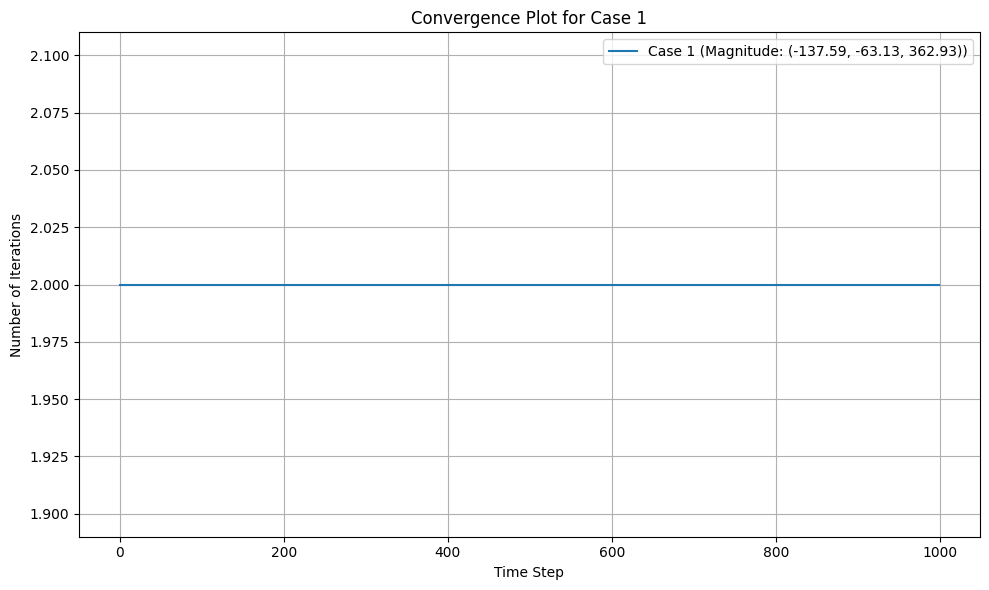

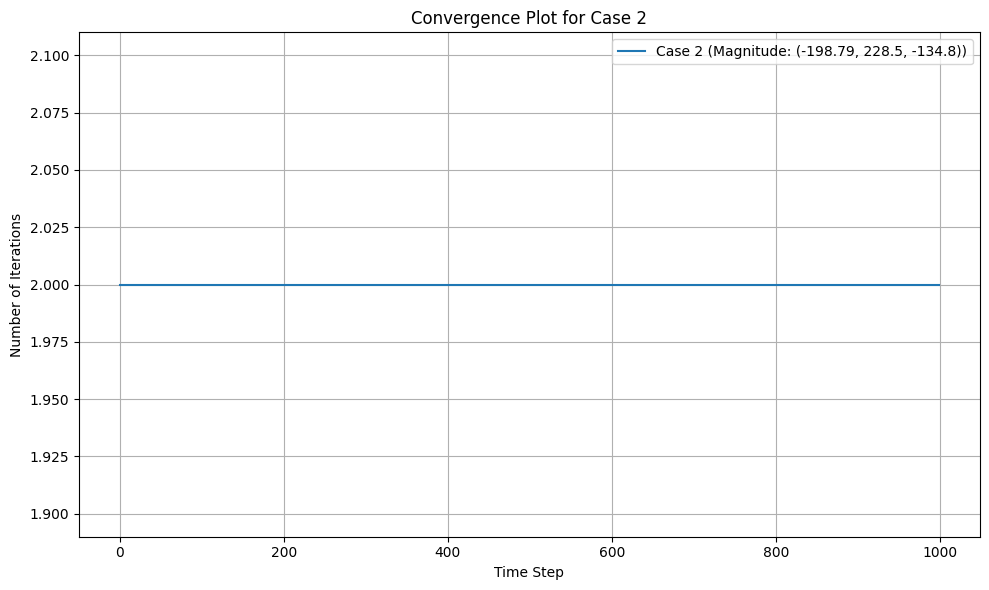

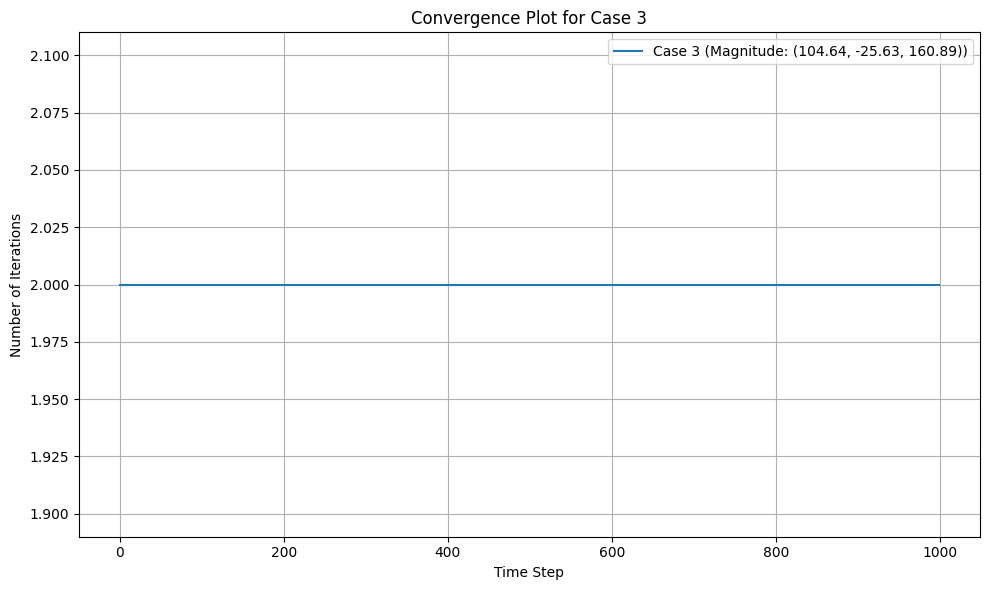

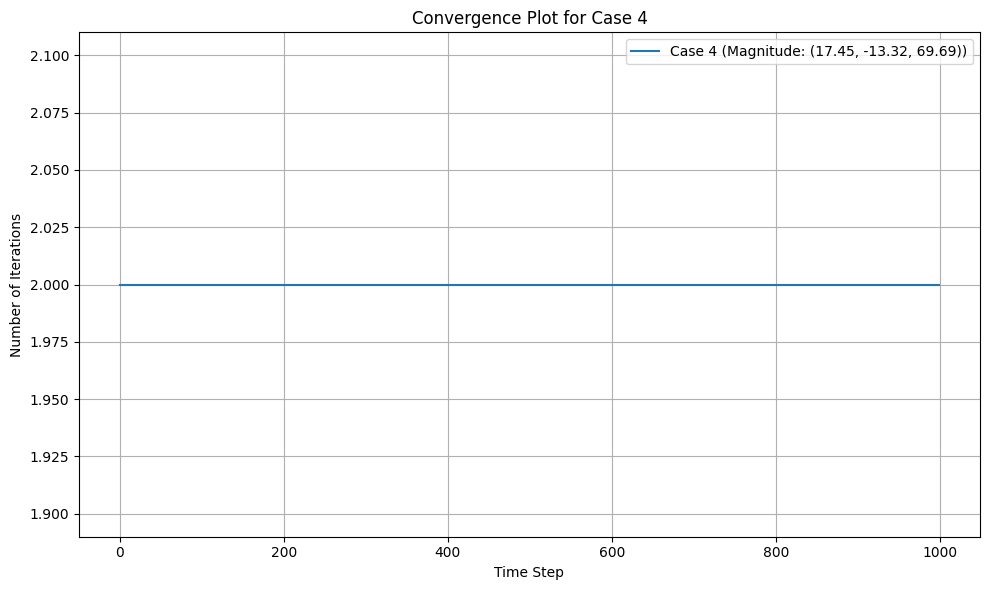

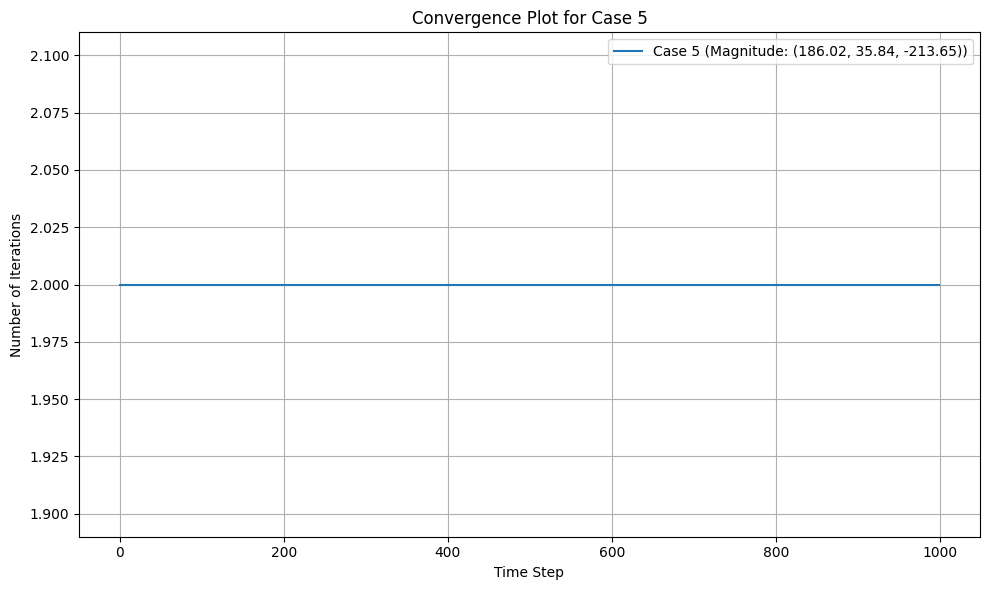

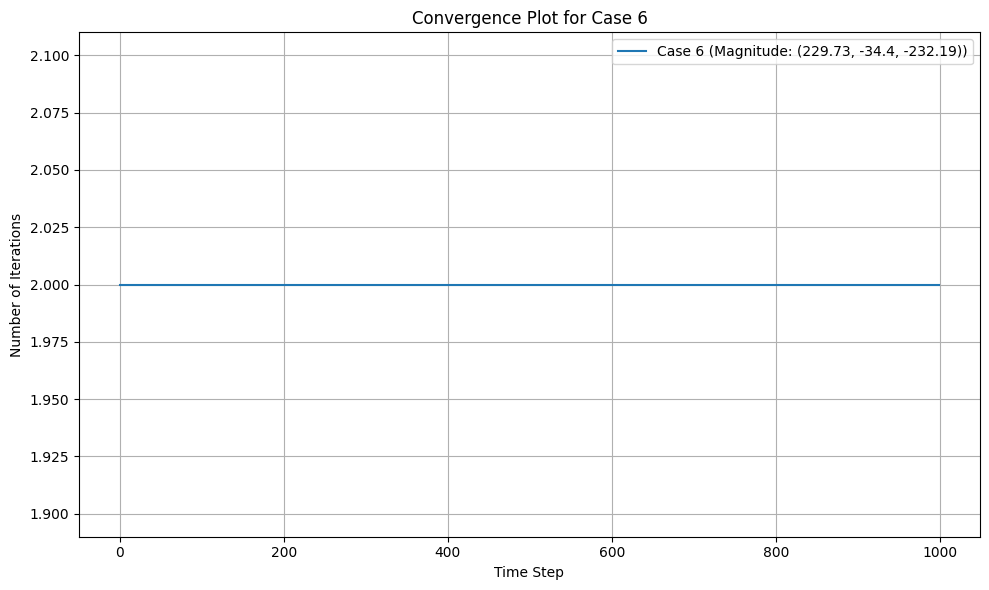

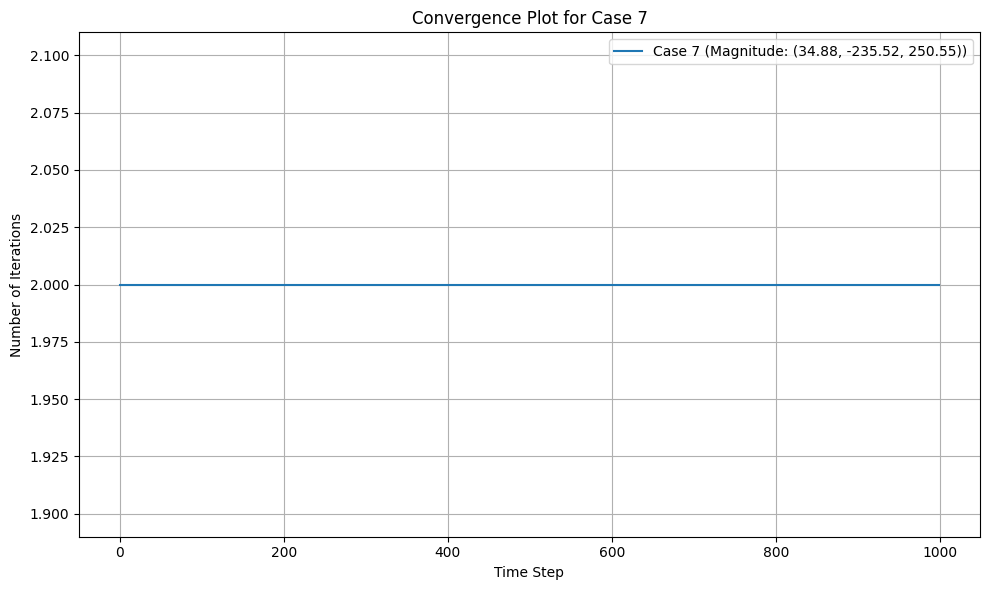

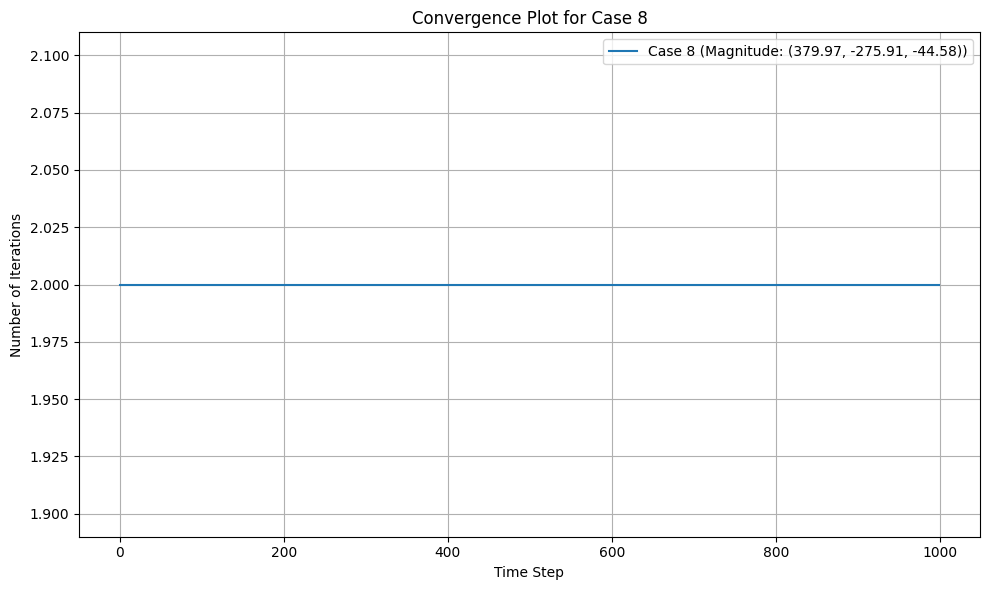

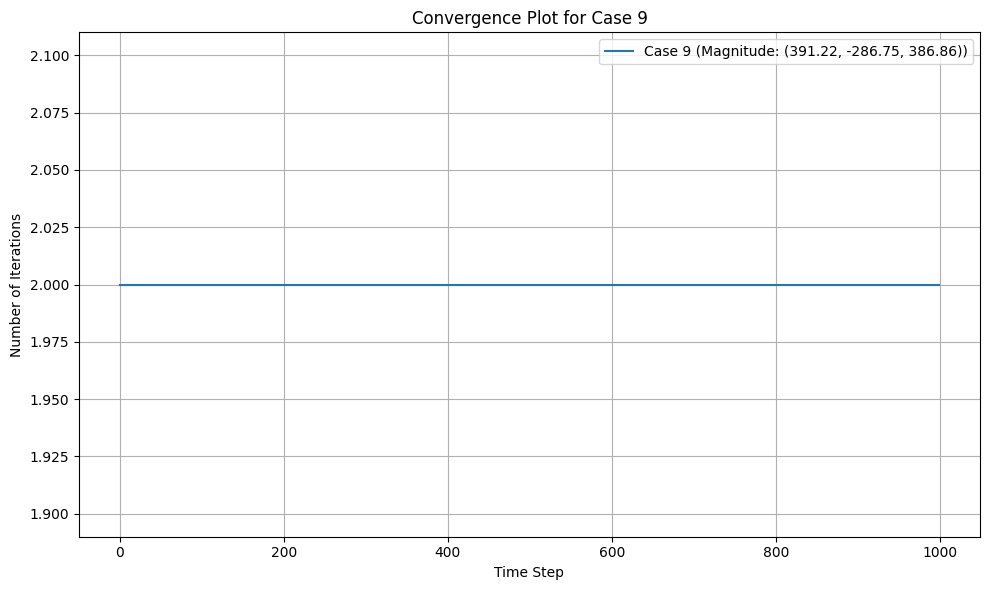

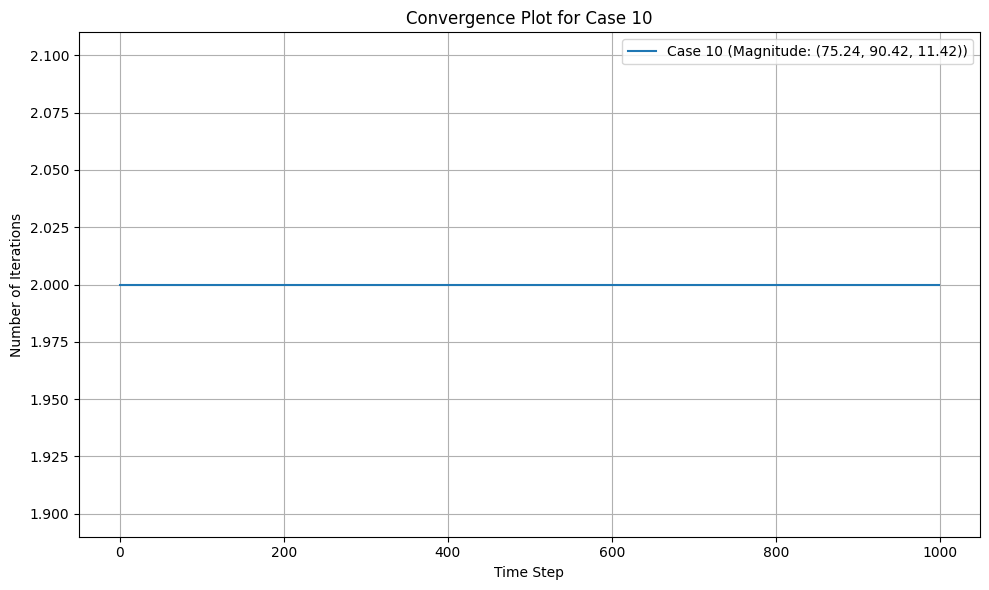

In [10]:
import matplotlib.pyplot as plt

# Plot convergence for each case
plt.figure(figsize=(10, 6))
for idx, case in enumerate(case_results):
    iterations = case['iterations_per_step']
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(iterations)), iterations, label=f'Case {idx + 1} (Magnitude: {magnitudes[idx]})')
    plt.xlabel('Time Step')
    plt.ylabel('Number of Iterations')
    plt.title(f'Convergence Plot for Case {idx + 1}')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


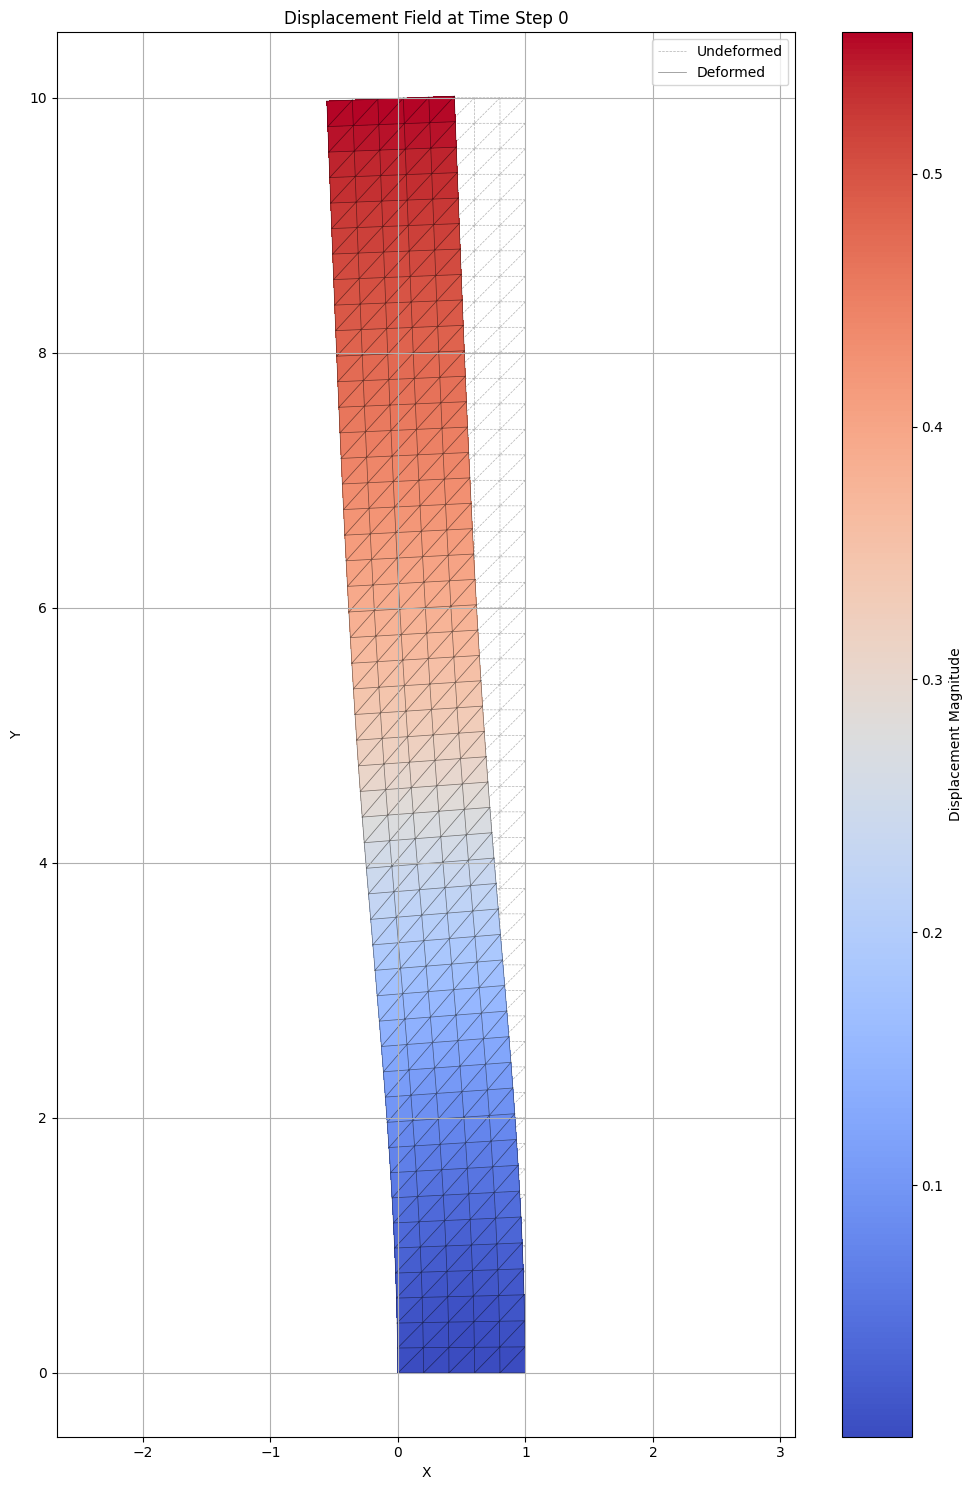


Displacement Statistics:
Maximum displacement magnitude: 5.59e-01
Minimum displacement magnitude: 0.00e+00
Mean displacement magnitude: 2.95e-01


In [11]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_displacement_timestep(x_data, time_step, mdpa_file, scale_factor=1e7):
    """
    Plot displacement field for a single time step.
    
    Parameters:
    -----------
    x_data: ndarray of shape (612, 5), displacement data
    time_step: int, which time step to plot
    mdpa_file: str, path to mdpa file
    scale_factor: float, scaling factor for displacements
    """
    # Read node coordinates and elements
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False
    
    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    x, y = float(parts[1]), float(parts[2])
                    node_coords.append([x, y])
                    
            if "Begin Elements SmallDisplacementElement2D3N" in line:
                reading_elements = True
                continue
            elif reading_elements and "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
                    elements.append([n1, n2, n3])
    
    node_coords = np.array(node_coords)
    elements = np.array(elements)
    
    # Get displacements for the specified time step
    displacements = x_data[:, time_step].reshape(-1, 2) * scale_factor
    disp_mag = np.sqrt(displacements[:, 0]**2 + displacements[:, 1]**2)
    
    # Calculate deformed coordinates
    deformed_coords = node_coords + displacements
    
    # Create figure
    fig, ax = plt.subplots(figsize=(10, 15))
    
    # Create triangulations
    triangulation_orig = tri.Triangulation(node_coords[:, 0], node_coords[:, 1], elements)
    triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
    
    # Plot undeformed mesh
    ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
    
    # Plot deformed mesh with displacement magnitude coloring
    tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm')
    ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')
    
    # Add colorbar
    plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
    
    # Set labels and title
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(f'Displacement Field at Time Step {time_step}')
    ax.grid(True)
    ax.axis('equal')
    ax.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print displacement statistics
    print("\nDisplacement Statistics:")
    print(f"Maximum displacement magnitude: {np.max(disp_mag):.2e}")
    print(f"Minimum displacement magnitude: {np.min(disp_mag):.2e}")
    print(f"Mean displacement magnitude: {np.mean(disp_mag):.2e}")

try:
    # Plot displacement for time step 0 (or change to any desired time step)
    plot_displacement_timestep(
        x_data=x,  # Your displacement data
        time_step=0,  # Change this to see different time steps
        mdpa_file=[file for file in os.listdir() if file.endswith('.mdpa')][0],
        scale_factor=1e6  # Adjust this to make displacements more visible
    )
except Exception as e:
    print(f"Error plotting displacement: {str(e)}")
    import traceback
    traceback.print_exc()

In [12]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.tri as tri
# import os
# from pathlib import Path

# def plot_displacement_at_timesteps(case_folder, mdpa_file, output_folder_name="displacement_plots", scale_factor=1e7):
#     """Plot displacement at each timestep and save plots as images in a new folder."""
#     try:
#         # Construct path for the new folder
#         output_folder = case_folder / output_folder_name

#         # Create the output folder if it doesn't exist
#         output_folder.mkdir(parents=True, exist_ok=True)

#         print(f"\nProcessing: {case_folder.name}")

#         # Load solution data
#         time = np.load(case_folder / "FOM_Solution" / "solution" / "time.npy")
#         displacement = np.load(case_folder / "FOM_Solution" / "solution" / "displacement.npy")

#         print(f"Loaded displacement data shape: {displacement.shape}")
#         print(f"Time steps available: {len(time)}")

#         # Read node coordinates and elements
#         node_coords = []
#         elements = []
#         reading_nodes = False
#         reading_elements = False

#         with open(mdpa_file, 'r') as file:
#             for line in file:
#                 line = line.strip()

#                 if "Begin Nodes" in line:
#                     reading_nodes = True
#                     continue
#                 elif "End Nodes" in line:
#                     reading_nodes = False
#                     continue
#                 elif reading_nodes and line:
#                     parts = line.split()
#                     if len(parts) >= 4:
#                         x, y = float(parts[1]), float(parts[2])
#                         node_coords.append([x, y])

#                 if "Begin Elements SmallDisplacementElement2D3N" in line:
#                     reading_elements = True
#                     continue
#                 elif reading_elements and "End Elements" in line:
#                     reading_elements = False
#                     continue
#                 elif reading_elements and line:
#                     parts = line.split()
#                     if len(parts) >= 5:
#                         n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
#                         elements.append([n1, n2, n3])

#         node_coords = np.array(node_coords)
#         elements = np.array(elements)

#         # Create triangulation for undeformed mesh
#         x = node_coords[:, 0]
#         y = node_coords[:, 1]
#         triangulation_orig = tri.Triangulation(x, y, elements)

#         # Find global displacement limits for consistent colorbar
#         disp_magnitudes = []
#         for step in range(len(time)):
#             disp = displacement[step].reshape(-1, 2) * scale_factor
#             disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
#             disp_magnitudes.append(disp_mag)

#         global_min = min(np.min(mag) for mag in disp_magnitudes)
#         global_max = max(np.max(mag) for mag in disp_magnitudes)

#         print(f"Plotting Information:")
#         print(f"Total plots: {len(time)}")
#         print(f"Time range: [{time[0]:.3f}, {time[-1]:.3f}] seconds")
#         print(f"Global displacement range: [{global_min:.2e}, {global_max:.2e}]")

#         # Loop through timesteps and plot
#         for frame in range(len(time)):
#             # Get displacements for current frame
#             disp = displacement[frame].reshape(-1, 2) * scale_factor
#             disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)

#             # Calculate deformed coordinates
#             deformed_coords = node_coords + disp

#             # Create figure and axis for each plot
#             fig, ax = plt.subplots(figsize=(10, 15))

#             # Plot undeformed mesh
#             ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')

#             # Plot deformed mesh with displacement magnitude coloring
#             triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
#             tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
#                                vmin=global_min, vmax=global_max)
#             ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')

#             # Set labels and title
#             ax.set_xlabel('X')
#             ax.set_ylabel('Y')
#             ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time) - 1})')

#             ax.grid(True)
#             ax.axis('equal')
#             ax.legend()

#             # Add colorbar only once
#             if frame == 0:
#                 plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')

#             plt.tight_layout()

#             # Save plot as image
#             output_file = output_folder / f"displacement_frame_{frame:04d}.png"
#             plt.savefig(output_file)
#             plt.close(fig)

#             # Print progress
#             if frame % 10 == 0:
#                 print(f"Processed and saved plot for frame {frame}/{len(time) - 1}")

#         print("All plots completed and saved!")
#         return True

#     except Exception as e:
#         print(f"Error processing {case_folder.name}: {str(e)}")
#         return False

# def process_all_cases(base_dir="Dynamic_solution", mdpa_file="2D_beam_udl_loading.mdpa", scale_factor=1e7):
#     """Process all cases in the Dynamic_solution directory."""
#     base_path = Path(base_dir)

#     # Find all case folders dynamically
#     case_folders = list(base_path.glob("case_*_magnitude_*"))

#     # Sort case folders by case number
#     def extract_case_number(folder_name):
#         # Extract the case number from the folder name (e.g., "case_1_magnitude_0.1" -> 1)
#         return int(folder_name.name.split("_")[1])

#     case_folders.sort(key=extract_case_number)

#     print(f"Found {len(case_folders)} cases to process")
#     print("\nProcessing order:")
#     for folder in case_folders:
#         print(f"  {folder.name}")

#     # Process each case
#     successful = 0
#     failed = 0

#     for folder in case_folders:
#         print("\n" + "=" * 50)
#         print(f"Processing {folder.name}")
#         print("=" * 50)

#         if plot_displacement_at_timesteps(folder, mdpa_file, scale_factor=scale_factor):
#             successful += 1
#         else:
#             failed += 1

#     print("\n" + "=" * 50)
#     print("Processing Complete!")
#     print(f"Successfully processed: {successful} cases")
#     print(f"Failed to process: {failed} cases")
#     print("=" * 50)

# # Run the processing
# if __name__ == "__main__":
#     try:
#         process_all_cases(
#             base_dir="Dynamic_solution",
#             mdpa_file="2D_beam_udl_loading.mdpa",
#             scale_factor=1e6  # Adjust this if needed
#         )
#     except Exception as e:
#         print(f"Error in main execution: {str(e)}")
#         import traceback
#         traceback.print_exc()



In [13]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import os
from pathlib import Path
import sys

def plot_displacement_at_timesteps(case_folder, mdpa_file, output_folder_name="displacement_plots", scale_factor=1e7):
    """Plot displacement at each timestep and save plots as images in a new folder."""
    try:
        # Construct path for the new folder
        output_folder = case_folder / output_folder_name

        # Create the output folder if it doesn't exist
        output_folder.mkdir(parents=True, exist_ok=True)

        print(f"\nProcessing: {case_folder.name}")

        # Load solution data
        time = np.load(case_folder / "FOM_Solution" / "solution" / "time.npy")
        displacement = np.load(case_folder / "FOM_Solution" / "solution" / "displacement.npy")

        print(f"Loaded displacement data shape: {displacement.shape}")
        print(f"Time steps available: {len(time)}")

        # Read node coordinates and elements
        node_coords = []
        elements = []
        reading_nodes = False
        reading_elements = False

        with open(mdpa_file, 'r') as file:
            for line in file:
                line = line.strip()

                if "Begin Nodes" in line:
                    reading_nodes = True
                    continue
                elif "End Nodes" in line:
                    reading_nodes = False
                    continue
                elif reading_nodes and line:
                    parts = line.split()
                    if len(parts) >= 4:
                        x, y = float(parts[1]), float(parts[2])
                        node_coords.append([x, y])

                if "Begin Elements SmallDisplacementElement2D3N" in line:
                    reading_elements = True
                    continue
                elif reading_elements and "End Elements" in line:
                    reading_elements = False
                    continue
                elif reading_elements and line:
                    parts = line.split()
                    if len(parts) >= 5:
                        n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
                        elements.append([n1, n2, n3])

        node_coords = np.array(node_coords)
        elements = np.array(elements)

        # Create triangulation for undeformed mesh
        x = node_coords[:, 0]
        y = node_coords[:, 1]
        triangulation_orig = tri.Triangulation(x, y, elements)

        # Find global displacement limits for consistent colorbar
        disp_magnitudes = []
        for step in range(len(time)):
            disp = displacement[step].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            disp_magnitudes.append(disp_mag)

        global_min = min(np.min(mag) for mag in disp_magnitudes)
        global_max = max(np.max(mag) for mag in disp_magnitudes)

        print(f"Plotting Information:")
        print(f"Total plots: {len(time)}")
        print(f"Time range: [{time[0]:.3f}, {time[-1]:.3f}] seconds")
        print(f"Global displacement range: [{global_min:.2e}, {global_max:.2e}]")

        # Loop through timesteps and plot
        for frame in range(len(time)):
            # Get displacements for current frame
            disp = displacement[frame].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)

            # Calculate deformed coordinates
            deformed_coords = node_coords + disp

            # Create figure and axis for each plot
            fig, ax = plt.subplots(figsize=(10, 15))

            # Plot undeformed mesh
            ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')

            # Plot deformed mesh with displacement magnitude coloring
            triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
            tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
                               vmin=global_min, vmax=global_max)
            ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')

            # Set labels and title
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time) - 1})')

            ax.grid(True)
            ax.axis('equal')
            ax.legend()

            # Add colorbar only once
            if frame == 0:
                plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')

            plt.tight_layout()

            # Save plot as image
            output_file = output_folder / f"displacement_frame_{frame:04d}.png"
            plt.savefig(output_file)
            plt.close(fig)

            # Print progress
            if frame % 10 == 0:
                print(f"Processed and saved plot for frame {frame}/{len(time) - 1}")

        print("All plots completed and saved!")
        return True

    except Exception as e:
        print(f"Error processing {case_folder.name}: {str(e)}")
        return False

def process_all_cases(base_dir="Dynamic_solution", mdpa_file="2D_beam_udl_loading.mdpa", scale_factor=1e7, num_files=None):
    """
    Process cases in the Dynamic_solution directory.
    
    Args:
        base_dir: Base directory containing case folders
        mdpa_file: Name of the mdpa file
        scale_factor: Scale factor for displacement visualization
        num_files: Number of files to process (None for all files)
    """
    base_path = Path(base_dir)

    # Find all case folders dynamically
    case_folders = list(base_path.glob("case_*_magnitude_*"))

    # Sort case folders by case number
    def extract_case_number(folder_name):
        # Extract the case number from the folder name (e.g., "case_1_magnitude_0.1" -> 1)
        return int(folder_name.name.split("_")[1])

    case_folders.sort(key=extract_case_number)
    
    total_cases = len(case_folders)
    
    if num_files is None:
        # If num_files is not provided, ask the user
        try:
            user_input = input(f"Found {total_cases} case folders. How many would you like to process? (Enter 'all' for all folders): ")
            if user_input.lower() == 'all':
                num_files = total_cases
            else:
                num_files = int(user_input)
                if num_files <= 0 or num_files > total_cases:
                    print(f"Invalid number. Using all {total_cases} files.")
                    num_files = total_cases
        except ValueError:
            print(f"Invalid input. Processing all {total_cases} files.")
            num_files = total_cases
    else:
        # Ensure num_files is valid
        num_files = min(max(1, num_files), total_cases)
    
    # Limit to the specified number of files
    case_folders = case_folders[:num_files]
    
    print(f"\nWill process {len(case_folders)} of {total_cases} cases")
    print("\nProcessing order:")
    for folder in case_folders:
        print(f"  {folder.name}")

    # Process each case
    successful = 0
    failed = 0

    for folder in case_folders:
        print("\n" + "=" * 50)
        print(f"Processing {folder.name}")
        print("=" * 50)

        if plot_displacement_at_timesteps(folder, mdpa_file, scale_factor=scale_factor):
            successful += 1
        else:
            failed += 1

    print("\n" + "=" * 50)
    print("Processing Complete!")
    print(f"Successfully processed: {successful} cases")
    print(f"Failed to process: {failed} cases")
    print(f"Skipped: {total_cases - num_files} cases")
    print("=" * 50)

# For Jupyter notebooks - run this directly
def run_processing(base_dir="Dynamic_solution", mdpa_file="2D_beam_udl_loading.mdpa", scale_factor=1e6, num_files=None):
    """Function to call from Jupyter notebook cells"""
    try:
        process_all_cases(
            base_dir=base_dir,
            mdpa_file=mdpa_file,
            scale_factor=scale_factor,
            num_files=num_files
        )
    except Exception as e:
        print(f"Error in execution: {str(e)}")
        import traceback
        traceback.print_exc()

# Detect if we're in Jupyter and run accordingly
if __name__ == "__main__":
    # Directly run the function without argparse for Jupyter
    run_processing()


Will process 1 of 10 cases

Processing order:
  case_1_magnitude_(-137.59, -63.13, 362.93)

Processing case_1_magnitude_(-137.59, -63.13, 362.93)

Processing: case_1_magnitude_(-137.59, -63.13, 362.93)
Loaded displacement data shape: (1001, 612)
Time steps available: 1001
Plotting Information:
Total plots: 1001
Time range: [0.000, 1.000] seconds
Global displacement range: [0.00e+00, 8.95e+00]
Processed and saved plot for frame 0/1000
Processed and saved plot for frame 10/1000
Processed and saved plot for frame 20/1000
Processed and saved plot for frame 30/1000
Processed and saved plot for frame 40/1000
Processed and saved plot for frame 50/1000
Processed and saved plot for frame 60/1000
Processed and saved plot for frame 70/1000
Processed and saved plot for frame 80/1000
Processed and saved plot for frame 90/1000
Processed and saved plot for frame 100/1000
Processed and saved plot for frame 110/1000
Processed and saved plot for frame 120/1000
Processed and saved plot for frame 130/100

C:\Users\shrey\AppData\Local\Temp\ipykernel_24072\908876638.py:117: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


Processed and saved plot for frame 470/1000
Processed and saved plot for frame 480/1000
Processed and saved plot for frame 490/1000
Processed and saved plot for frame 500/1000
Processed and saved plot for frame 510/1000
Processed and saved plot for frame 520/1000
Processed and saved plot for frame 530/1000
Processed and saved plot for frame 540/1000
Processed and saved plot for frame 550/1000
Processed and saved plot for frame 560/1000
Processed and saved plot for frame 570/1000
Processed and saved plot for frame 580/1000


C:\Users\shrey\AppData\Local\Temp\ipykernel_24072\908876638.py:121: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(output_file)


Processed and saved plot for frame 590/1000
Processed and saved plot for frame 600/1000
Processed and saved plot for frame 610/1000
Processed and saved plot for frame 620/1000
Processed and saved plot for frame 630/1000
Processed and saved plot for frame 640/1000
Processed and saved plot for frame 650/1000
Processed and saved plot for frame 660/1000
Processed and saved plot for frame 670/1000
Processed and saved plot for frame 680/1000
Processed and saved plot for frame 690/1000
Processed and saved plot for frame 700/1000
Processed and saved plot for frame 710/1000
Processed and saved plot for frame 720/1000
Processed and saved plot for frame 730/1000
Processed and saved plot for frame 740/1000
Processed and saved plot for frame 750/1000
Processed and saved plot for frame 760/1000
Processed and saved plot for frame 770/1000
Processed and saved plot for frame 780/1000
Processed and saved plot for frame 790/1000
Processed and saved plot for frame 800/1000
Processed and saved plot for fra

In [14]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.tri as tri
# from matplotlib.animation import FuncAnimation, PillowWriter
# import os
# from pathlib import Path

# def create_displacement_animation(case_folder, mdpa_file, scale_factor=1e7, step_interval=100):
#     """
#     Create an animated GIF of displacement field for a specific case.
    
#     Parameters:
#     -----------
#     case_folder: Path object, full path to case folder
#     mdpa_file: str, path to mdpa file
#     scale_factor: float, scaling factor for displacements
#     step_interval: int, time in milliseconds between frames
#     """
#     try:
#         # Create output filename from case folder name
#         output_file = case_folder / 'displacement_animation_scaled.gif'
        
#         print(f"\nProcessing: {case_folder.name}")
        
#         # Load solution data
#         time = np.load(case_folder / "solution" / "time.npy")
#         displacement = np.load(case_folder / "solution" / "displacement.npy")
        
#         print(f"Loaded displacement data shape: {displacement.shape}")
#         print(f"Time steps available: {len(time)}")
        
#         # Read node coordinates and elements
#         node_coords = []
#         elements = []
#         reading_nodes = False
#         reading_elements = False
        
#         with open(mdpa_file, 'r') as file:
#             for line in file:
#                 line = line.strip()
                
#                 if "Begin Nodes" in line:
#                     reading_nodes = True
#                     continue
#                 elif "End Nodes" in line:
#                     reading_nodes = False
#                     continue
#                 elif reading_nodes and line:
#                     parts = line.split()
#                     if len(parts) >= 4:
#                         x, y = float(parts[1]), float(parts[2])
#                         node_coords.append([x, y])
                        
#                 if "Begin Elements SmallDisplacementElement2D3N" in line:
#                     reading_elements = True
#                     continue
#                 elif reading_elements and "End Elements" in line:
#                     reading_elements = False
#                     continue
#                 elif reading_elements and line:
#                     parts = line.split()
#                     if len(parts) >= 5:
#                         n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
#                         elements.append([n1, n2, n3])
        
#         node_coords = np.array(node_coords)
#         elements = np.array(elements)
        
#         # Create figure
#         fig, ax = plt.subplots(figsize=(10, 15))
        
#         # Create base triangulation for undeformed mesh
#         x = node_coords[:, 0]
#         y = node_coords[:, 1]
#         triangulation_orig = tri.Triangulation(x, y, elements)
        
#         # Find global displacement limits for consistent colorbar
#         disp_magnitudes = []
#         for step in range(len(time)):
#             disp = displacement[step].reshape(-1, 2) * scale_factor
#             disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
#             disp_magnitudes.append(disp_mag)
        
#         global_min = min(np.min(mag) for mag in disp_magnitudes)
#         global_max = max(np.max(mag) for mag in disp_magnitudes)
        
#         print(f"Animation Information:")
#         print(f"Total frames: {len(time)}")
#         print(f"Time range: [{time[0]:.3f}, {time[-1]:.3f}] seconds")
#         print(f"Global displacement range: [{global_min:.2e}, {global_max:.2e}]")
        
#         def update(frame):
#             ax.clear()
            
#             # Get displacements for current frame
#             disp = displacement[frame].reshape(-1, 2) * scale_factor
#             disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            
#             # Calculate deformed coordinates
#             deformed_coords = node_coords + disp
            
#             # Plot undeformed mesh
#             ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
            
#             # Plot deformed mesh with displacement magnitude coloring
#             triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
#             tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
#                              vmin=global_min, vmax=global_max)
#             ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')
            
#             # Set labels and title
#             ax.set_xlabel('X')
#             ax.set_ylabel('Y')
#             ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
            
#             ax.grid(True)
#             ax.axis('equal')
#             ax.legend()
            
#             # Add colorbar only once
#             if frame == 0:
#                 plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
            
#             plt.tight_layout()
            
#             # Print progress
#             if frame % 10 == 0:
#                 print(f"Processing frame {frame}/{len(time)-1}")
        
#         # Create animation
#         print("Creating animation...")
#         anim = FuncAnimation(fig, update, frames=len(time), interval=step_interval)
        
#         # Save animation
#         print(f"Saving animation to {output_file}")
#         writer = PillowWriter(fps=1000/step_interval)
#         anim.save(output_file, writer=writer)
        
#         plt.close()
#         print("Animation completed!")
        
#         return True
        
#     except Exception as e:
#         print(f"Error processing {case_folder.name}: {str(e)}")
#         return False
    
# def process_all_cases(base_dir="Dynamic_solution", mdpa_file="2D_beam_udl_loading.mdpa", scale_factor=1e7):
#     """Process all cases in the Dynamic_solution directory."""
#     base_path = Path(base_dir)
    
#     # Find all case folders dynamically
#     case_folders = list(base_path.glob("case_*_magnitude_*"))
    
#     # Sort case folders by case number
#     def extract_case_number(folder_name):
#         # Extract the case number from the folder name (e.g., "case_1_magnitude_0.1" -> 1)
#         return int(folder_name.name.split("_")[1])
    
#     case_folders.sort(key=extract_case_number)
    
#     print(f"Found {len(case_folders)} cases to process")
#     print("\nProcessing order:")
#     for folder in case_folders:
#         print(f"  {folder.name}")
    
#     # Process each case
#     successful = 0
#     failed = 0
    
#     for folder in case_folders:
#         print("\n" + "="*50)
#         print(f"Processing {folder.name}")
#         print("="*50)
        
#         # Adjust path to include Numerical_Solution subfolder
#         solution_folder = folder / "FOM_Solution"
        
#         if solution_folder.exists():
#             if create_displacement_animation(solution_folder, mdpa_file, scale_factor):
#                 successful += 1
#             else:
#                 failed += 1
#         else:
#             print(f"Error: Numerical_Solution folder not found in {folder.name}")
#             failed += 1
    
#     print("\n" + "="*50)
#     print("Processing Complete!")
#     print(f"Successfully processed: {successful} cases")
#     print(f"Failed to process: {failed} cases")
#     print("="*50)

# # Run the processing
# if __name__ == "__main__":
#     try:
#         process_all_cases(
#             base_dir="Dynamic_solution",
#             mdpa_file=[file for file in os.listdir() if file.endswith('.mdpa')][0],
#             scale_factor=1e6  # Adjust this if needed
#         )
#     except Exception as e:
#         print(f"Error in main execution: {str(e)}")
#         import traceback
#         traceback.print_exc()

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.animation import FuncAnimation, PillowWriter
import os
from pathlib import Path

def create_displacement_animation(case_folder, mdpa_file, scale_factor=1e7, step_interval=100):
    """
    Create an animated GIF of displacement field for a specific case.
    
    Parameters:
    -----------
    case_folder: Path object, full path to case folder
    mdpa_file: str, path to mdpa file
    scale_factor: float, scaling factor for displacements
    step_interval: int, time in milliseconds between frames
    """
    try:
        # Create output filename from case folder name
        output_file = case_folder / 'displacement_animation_scaled.gif'
        
        print(f"\nProcessing: {case_folder.name}")
        
        # Load solution data
        time = np.load(case_folder / "solution" / "time.npy")
        displacement = np.load(case_folder / "solution" / "displacement.npy")
        
        print(f"Loaded displacement data shape: {displacement.shape}")
        print(f"Time steps available: {len(time)}")
        
        # Read node coordinates and elements
        node_coords = []
        elements = []
        reading_nodes = False
        reading_elements = False
        
        with open(mdpa_file, 'r') as file:
            for line in file:
                line = line.strip()
                
                if "Begin Nodes" in line:
                    reading_nodes = True
                    continue
                elif "End Nodes" in line:
                    reading_nodes = False
                    continue
                elif reading_nodes and line:
                    parts = line.split()
                    if len(parts) >= 4:
                        x, y = float(parts[1]), float(parts[2])
                        node_coords.append([x, y])
                        
                if "Begin Elements SmallDisplacementElement2D3N" in line:
                    reading_elements = True
                    continue
                elif reading_elements and "End Elements" in line:
                    reading_elements = False
                    continue
                elif reading_elements and line:
                    parts = line.split()
                    if len(parts) >= 5:
                        n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
                        elements.append([n1, n2, n3])
        
        node_coords = np.array(node_coords)
        elements = np.array(elements)
        
        # Create figure
        fig, ax = plt.subplots(figsize=(10, 15))
        
        # Create base triangulation for undeformed mesh
        x = node_coords[:, 0]
        y = node_coords[:, 1]
        triangulation_orig = tri.Triangulation(x, y, elements)
        
        # Find global displacement limits for consistent colorbar
        disp_magnitudes = []
        for step in range(len(time)):
            disp = displacement[step].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            disp_magnitudes.append(disp_mag)
        
        global_min = min(np.min(mag) for mag in disp_magnitudes)
        global_max = max(np.max(mag) for mag in disp_magnitudes)
        
        print(f"Animation Information:")
        print(f"Total frames: {len(time)}")
        print(f"Time range: [{time[0]:.3f}, {time[-1]:.3f}] seconds")
        print(f"Global displacement range: [{global_min:.2e}, {global_max:.2e}]")
        
        def update(frame):
            ax.clear()
            
            # Get displacements for current frame
            disp = displacement[frame].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            
            # Calculate deformed coordinates
            deformed_coords = node_coords + disp
            
            # Plot undeformed mesh
            ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
            
            # Plot deformed mesh with displacement magnitude coloring
            triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
            tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
                             vmin=global_min, vmax=global_max)
            ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')
            
            # Set labels and title
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
            
            ax.grid(True)
            ax.axis('equal')
            ax.legend()
            
            # Add colorbar only once
            if frame == 0:
                plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
            
            plt.tight_layout()
            
            # Print progress
            if frame % 10 == 0:
                print(f"Processing frame {frame}/{len(time)-1}")
        
        # Create animation
        print("Creating animation...")
        anim = FuncAnimation(fig, update, frames=len(time), interval=step_interval)
        
        # Save animation
        print(f"Saving animation to {output_file}")
        writer = PillowWriter(fps=1000/step_interval)
        anim.save(output_file, writer=writer)
        
        plt.close()
        print("Animation completed!")
        
        return True
        
    except Exception as e:
        print(f"Error processing {case_folder.name}: {str(e)}")
        return False

def get_case_folders(base_dir="Dynamic_solution"):
    """Get all available case folders and sort them by case number."""
    base_path = Path(base_dir)
    
    # Find all case folders dynamically
    case_folders = list(base_path.glob("case_*_magnitude_*"))
    
    # Sort case folders by case number
    def extract_case_number(folder_name):
        # Extract the case number from the folder name (e.g., "case_1_magnitude_0.1" -> 1)
        return int(folder_name.name.split("_")[1])
    
    case_folders.sort(key=extract_case_number)
    return case_folders

def user_select_cases(case_folders):
    """Allow user to select which cases to process."""
    print("\nAvailable case folders:")
    for i, folder in enumerate(case_folders, 1):
        print(f"{i}. {folder.name}")
    
    while True:
        try:
            user_input = input("\nEnter case numbers to process (comma-separated, e.g., '1,3,5' or 'all' for all cases): ")
            
            if user_input.lower() == 'all':
                print("Processing all cases.")
                selected_folders = case_folders
                break
            
            # Get user-selected case numbers
            selected_indices = [int(x.strip()) for x in user_input.split(',')]
            
            # Validate indices
            if any(idx < 1 or idx > len(case_folders) for idx in selected_indices):
                print(f"Error: Please enter valid case numbers between 1 and {len(case_folders)}")
                continue
            
            # Get the selected folders
            selected_folders = [case_folders[idx-1] for idx in selected_indices]
            
            if not selected_folders:
                print("No valid cases selected.")
                continue
                
            print(f"\nSelected {len(selected_folders)} cases to process:")
            for folder in selected_folders:
                print(f"  {folder.name}")
            
            break
            
        except ValueError:
            print("Error: Please enter valid numbers separated by commas.")
        except Exception as e:
            print(f"Error: {str(e)}")
    
    return selected_folders

def process_selected_cases(selected_folders, mdpa_file, scale_factor=1e6):
    """Process only the selected case folders."""
    successful = 0
    failed = 0
    
    for folder in selected_folders:
        print("\n" + "="*50)
        print(f"Processing {folder.name}")
        print("="*50)
        
        # Adjust path to include FOM_Solution subfolder
        solution_folder = folder / "FOM_Solution"
        
        if solution_folder.exists():
            if create_displacement_animation(solution_folder, mdpa_file, scale_factor):
                successful += 1
            else:
                failed += 1
        else:
            print(f"Error: FOM_Solution folder not found in {folder.name}")
            failed += 1
    
    print("\n" + "="*50)
    print("Processing Complete!")
    print(f"Successfully processed: {successful} cases")
    print(f"Failed to process: {failed} cases")
    print("="*50)

# Run the processing
if __name__ == "__main__":
    try:
        base_dir = "Dynamic_solution"
        
        # Find MDPA file
        mdpa_files = [file for file in os.listdir() if file.endswith('.mdpa')]
        if not mdpa_files:
            print("Error: No .mdpa files found in the current directory.")
            exit(1)
        mdpa_file = mdpa_files[0]
        
        # Get available case folders
        case_folders = get_case_folders(base_dir)
        
        if not case_folders:
            print(f"Error: No case folders found in {base_dir}.")
            exit(1)
        
        print(f"Found {len(case_folders)} total cases")
        
        # Let user select cases
        selected_folders = user_select_cases(case_folders)
        
        # Use the same scale factor as in the original code
        scale_factor = 1e6
        
        process_selected_cases(selected_folders, mdpa_file, scale_factor)
        
    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()

Found 10 total cases

Available case folders:
1. case_1_magnitude_(-137.59, -63.13, 362.93)
2. case_2_magnitude_(-198.79, 228.5, -134.8)
3. case_3_magnitude_(104.64, -25.63, 160.89)
4. case_4_magnitude_(17.45, -13.32, 69.69)
5. case_5_magnitude_(186.02, 35.84, -213.65)
6. case_6_magnitude_(229.73, -34.4, -232.19)
7. case_7_magnitude_(34.88, -235.52, 250.55)
8. case_8_magnitude_(379.97, -275.91, -44.58)
9. case_9_magnitude_(391.22, -286.75, 386.86)
10. case_10_magnitude_(75.24, 90.42, 11.42)

Selected 1 cases to process:
  case_1_magnitude_(-137.59, -63.13, 362.93)

Processing case_1_magnitude_(-137.59, -63.13, 362.93)

Processing: FOM_Solution
Loaded displacement data shape: (1001, 612)
Time steps available: 1001
Animation Information:
Total frames: 1001
Time range: [0.000, 1.000] seconds
Global displacement range: [0.00e+00, 8.95e+00]
Creating animation...
Saving animation to Dynamic_solution\case_1_magnitude_(-137.59, -63.13, 362.93)\FOM_Solution\displacement_animation_scaled.gif
Pro

In [16]:
# import numpy as np
# import matplotlib.pyplot as plt
# import matplotlib.tri as tri
# from matplotlib.animation import FuncAnimation, PillowWriter
# import os
# from pathlib import Path

# def create_displacement_animation(case_folder, mdpa_file, scale_factor=1e7, step_interval=100):
#     """
#     Create an animated GIF of displacement field for a specific case.
    
#     Parameters:
#     -----------
#     case_folder: Path object, full path to case folder
#     mdpa_file: str, path to mdpa file
#     scale_factor: float, scaling factor for displacements
#     step_interval: int, time in milliseconds between frames
#     """
#     try:
#         # Create output filename from case folder name
#         output_file = case_folder / 'displacement_animation.gif'
        
#         print(f"\nProcessing: {case_folder.name}")
        
#         # Load solution data
#         time = np.load(case_folder / "solution" / "time.npy")
#         displacement = np.load(case_folder / "solution" / "displacement.npy")
        
#         print(f"Loaded displacement data shape: {displacement.shape}")
#         print(f"Time steps available: {len(time)}")
        
#         # Read node coordinates and elements
#         node_coords = []
#         elements = []
#         reading_nodes = False
#         reading_elements = False
        
#         with open(mdpa_file, 'r') as file:
#             for line in file:
#                 line = line.strip()
                
#                 if "Begin Nodes" in line:
#                     reading_nodes = True
#                     continue
#                 elif "End Nodes" in line:
#                     reading_nodes = False
#                     continue
#                 elif reading_nodes and line:
#                     parts = line.split()
#                     if len(parts) >= 4:
#                         x, y = float(parts[1]), float(parts[2])
#                         node_coords.append([x, y])
                        
#                 if "Begin Elements SmallDisplacementElement2D3N" in line:
#                     reading_elements = True
#                     continue
#                 elif reading_elements and "End Elements" in line:
#                     reading_elements = False
#                     continue
#                 elif reading_elements and line:
#                     parts = line.split()
#                     if len(parts) >= 5:
#                         n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
#                         elements.append([n1, n2, n3])
        
#         node_coords = np.array(node_coords)
#         elements = np.array(elements)
        
#         # Create figure
#         fig, ax = plt.subplots(figsize=(10, 15))
        
#         # Create base triangulation for undeformed mesh
#         x = node_coords[:, 0]
#         y = node_coords[:, 1]
#         triangulation_orig = tri.Triangulation(x, y, elements)
        
#         # Find global displacement limits for consistent colorbar
#         disp_magnitudes = []
#         for step in range(len(time)):
#             disp = displacement[step].reshape(-1, 2) * scale_factor
#             disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
#             disp_magnitudes.append(disp_mag)
        
#         global_min = min(np.min(mag) for mag in disp_magnitudes)
#         global_max = max(np.max(mag) for mag in disp_magnitudes)
        
#         print(f"Animation Information:")
#         print(f"Total frames: {len(time)}")
#         print(f"Time range: [{time[0]:.3f}, {time[-1]:.3f}] seconds")
#         print(f"Global displacement range: [{global_min:.2e}, {global_max:.2e}]")
        
#         def update(frame):
#             ax.clear()
            
#             # Get displacements for current frame
#             disp = displacement[frame].reshape(-1, 2) * scale_factor
#             disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            
#             # Calculate deformed coordinates
#             deformed_coords = node_coords + disp
            
#             # Plot undeformed mesh
#             ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
            
#             # Plot deformed mesh with displacement magnitude coloring
#             triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
#             tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
#                              vmin=global_min, vmax=global_max)
#             ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')
            
#             # Set labels and title
#             ax.set_xlabel('X')
#             ax.set_ylabel('Y')
#             ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
            
#             ax.grid(True)
#             ax.axis('equal')
#             ax.legend()
            
#             # Add colorbar only once
#             if frame == 0:
#                 plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
            
#             plt.tight_layout()
            
#             # Print progress
#             if frame % 10 == 0:
#                 print(f"Processing frame {frame}/{len(time)-1}")
        
#         # Create animation
#         print("Creating animation...")
#         anim = FuncAnimation(fig, update, frames=len(time), interval=step_interval)
        
#         # Save animation
#         print(f"Saving animation to {output_file}")
#         writer = PillowWriter(fps=1000/step_interval)
#         anim.save(output_file, writer=writer)
        
#         plt.close()
#         print("Animation completed!")
        
#         return True
        
#     except Exception as e:
#         print(f"Error processing {case_folder.name}: {str(e)}")
#         return False
    
# def process_all_cases(base_dir="Dynamic_solution", mdpa_file="2D_beam_udl_loading.mdpa", scale_factor=1e7):
#     """Process all cases in the Dynamic_solution directory."""
#     base_path = Path(base_dir)
    
#     # Find all case folders dynamically
#     case_folders = list(base_path.glob("case_*_magnitude_*"))
    
#     # Sort case folders by case number
#     def extract_case_number(folder_name):
#         # Extract the case number from the folder name (e.g., "case_1_magnitude_0.1" -> 1)
#         return int(folder_name.name.split("_")[1])
    
#     case_folders.sort(key=extract_case_number)
    
#     print(f"Found {len(case_folders)} cases to process")
#     print("\nProcessing order:")
#     for folder in case_folders:
#         print(f"  {folder.name}")
    
#     # Process each case
#     successful = 0
#     failed = 0
    
#     for folder in case_folders:
#         print("\n" + "="*50)
#         print(f"Processing {folder.name}")
#         print("="*50)
        
#         # Adjust path to include Numerical_Solution subfolder
#         solution_folder = folder / "Numerical_Solution"
        
#         if solution_folder.exists():
#             if create_displacement_animation(solution_folder, mdpa_file, scale_factor):
#                 successful += 1
#             else:
#                 failed += 1
#         else:
#             print(f"Error: Numerical_Solution folder not found in {folder.name}")
#             failed += 1
    
#     print("\n" + "="*50)
#     print("Processing Complete!")
#     print(f"Successfully processed: {successful} cases")
#     print(f"Failed to process: {failed} cases")
#     print("="*50)

# # Run the processing
# if __name__ == "__main__":
#     try:
#         process_all_cases(
#             base_dir="Dynamic_solution",
#             mdpa_file=[file for file in os.listdir() if file.endswith('.mdpa')][0],
#             scale_factor=1  # Adjust this if needed
#         )
#     except Exception as e:
#         print(f"Error in main execution: {str(e)}")
#         import traceback
#         traceback.print_exc()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import os
from pathlib import Path

def save_displacement_frames(case_folder, mdpa_file, scale_factor=1e7):
    """
    Save displacement screenshots for each time step as .png images.
    
    Parameters:
    -----------
    case_folder: Path object, full path to case folder
    mdpa_file: str, path to mdpa file
    scale_factor: float, scaling factor for displacements
    """
    try:
        print(f"\n📂 Processing: {case_folder.name}")
        
        # Load solution data
        time_file = case_folder / "solution" / "time.npy"
        displacement_file = case_folder / "solution" / "displacement.npy"
        time = np.load(time_file)
        displacement = np.load(displacement_file)

        print(f"📥 Loaded:")
        print(f"   Time file        : {time_file.resolve()}")
        print(f"   Displacement file: {displacement_file.resolve()}")
        print(f"   Shape of displacement data: {displacement.shape}")
        print(f"   Number of time steps: {len(time)}")
        
        # Read mesh
        node_coords = []
        elements = []
        reading_nodes = False
        reading_elements = False
        
        print(f"📄 Reading mesh from: {Path(mdpa_file).resolve()}")
        with open(mdpa_file, 'r') as file:
            for line in file:
                line = line.strip()
                
                if "Begin Nodes" in line:
                    reading_nodes = True
                    continue
                elif "End Nodes" in line:
                    reading_nodes = False
                    continue
                elif reading_nodes and line:
                    parts = line.split()
                    if len(parts) >= 4:
                        x, y = float(parts[1]), float(parts[2])
                        node_coords.append([x, y])
                        
                if "Begin Elements SmallDisplacementElement2D3N" in line:
                    reading_elements = True
                    continue
                elif reading_elements and "End Elements" in line:
                    reading_elements = False
                    continue
                elif reading_elements and line:
                    parts = line.split()
                    if len(parts) >= 5:
                        n1, n2, n3 = int(parts[2])-1, int(parts[3])-1, int(parts[4])-1
                        elements.append([n1, n2, n3])
        
        node_coords = np.array(node_coords)
        elements = np.array(elements)
        
        # Create triangulation
        triangulation_orig = tri.Triangulation(node_coords[:, 0], node_coords[:, 1], elements)

        # Output folder for images
        output_dir = case_folder / "solution" / "displacement_frames"
        output_dir.mkdir(exist_ok=True)
        print(f"🖼️  Saving displacement plots to: {output_dir.resolve()}")
        
        # Global color scale
        disp_magnitudes = []
        for step in range(len(time)):
            disp = displacement[step].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            disp_magnitudes.append(disp_mag)

        global_min = min(np.min(mag) for mag in disp_magnitudes)
        global_max = max(np.max(mag) for mag in disp_magnitudes)
        print(f"📊 Displacement magnitude range: [{global_min:.2e}, {global_max:.2e}]")

        # Plot and save each frame
        for frame in range(len(time)):
            fig, ax = plt.subplots(figsize=(10, 15))
            disp = displacement[frame].reshape(-1, 2) * scale_factor
            disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
            deformed_coords = node_coords + disp

            triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)

            ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
            tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
                               vmin=global_min, vmax=global_max)
            ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')

            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
            ax.grid(True)
            ax.axis('equal')
            ax.legend()
            plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
            plt.tight_layout()

            frame_path = output_dir / f"frame_{frame:04d}.png"
            plt.savefig(frame_path)
            plt.close()
            print(f"✅ Saved: {frame_path.name}")

        print(f"🎉 All displacement frames saved for: {case_folder.name}")
        return True

    except Exception as e:
        print(f"❌ Error processing {case_folder.name}: {str(e)}")
        return False


def process_all_cases(base_dir="Dynamic_solution", mdpa_file="2D_beam_udl_loading.mdpa", scale_factor=1e7):
    """Process all cases in the Dynamic_solution directory by saving PNG frames instead of GIFs."""
    base_path = Path(base_dir)
    case_folders = list(base_path.glob("case_*_magnitude_*"))

    # Sort folders
    def extract_case_number(folder_name):
        return int(folder_name.name.split("_")[1])

    case_folders.sort(key=extract_case_number)

    print(f"🔍 Found {len(case_folders)} cases to process")
    print("📦 Processing order:")
    for folder in case_folders:
        print(f"  - {folder.name}")

    successful = 0
    failed = 0

    for folder in case_folders:
        print("\n" + "=" * 60)
        print(f"🚀 Processing {folder.name}")
        print("=" * 60)

        solution_folder = folder / "Numerical_Solution"

        if solution_folder.exists():
            if save_displacement_frames(solution_folder, mdpa_file, scale_factor):
                successful += 1
            else:
                failed += 1
        else:
            print(f"❌ Error: Numerical_Solution folder not found in {folder.name}")
            failed += 1

    print("\n" + "=" * 60)
    print("✅ Processing Complete!")
    print(f"✅ Successfully processed: {successful}")
    print(f"❌ Failed to process: {failed}")
    print("=" * 60)


# Run the processing
if __name__ == "__main__":
    try:
        process_all_cases(
            base_dir="Dynamic_solution",
            mdpa_file=[file for file in os.listdir() if file.endswith('.mdpa')][0],
            scale_factor=1e6
        )
    except Exception as e:
        print(f"❌ Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()


🔍 Found 10 cases to process
📦 Processing order:
  - case_1_magnitude_(-137.59, -63.13, 362.93)
  - case_2_magnitude_(-198.79, 228.5, -134.8)
  - case_3_magnitude_(104.64, -25.63, 160.89)
  - case_4_magnitude_(17.45, -13.32, 69.69)
  - case_5_magnitude_(186.02, 35.84, -213.65)
  - case_6_magnitude_(229.73, -34.4, -232.19)
  - case_7_magnitude_(34.88, -235.52, 250.55)
  - case_8_magnitude_(379.97, -275.91, -44.58)
  - case_9_magnitude_(391.22, -286.75, 386.86)
  - case_10_magnitude_(75.24, 90.42, 11.42)

🚀 Processing case_1_magnitude_(-137.59, -63.13, 362.93)
❌ Error: Numerical_Solution folder not found in case_1_magnitude_(-137.59, -63.13, 362.93)

🚀 Processing case_2_magnitude_(-198.79, 228.5, -134.8)
❌ Error: Numerical_Solution folder not found in case_2_magnitude_(-198.79, 228.5, -134.8)

🚀 Processing case_3_magnitude_(104.64, -25.63, 160.89)
❌ Error: Numerical_Solution folder not found in case_3_magnitude_(104.64, -25.63, 160.89)

🚀 Processing case_4_magnitude_(17.45, -13.32, 69.69)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import time
from tqdm import tqdm
from pathlib import Path
from tabulate import tabulate


s = f_constrained.shape[0]
num_cases = f_constrained.shape[1]

def constant_force_factory(F):
    return lambda t: F

# Initial velocity and identity/zero matrices
v0 = np.zeros((s, num_cases))
I = np.eye(s)
Z = np.zeros((s, s))

# Combined matrices for state-space formulation
M_star = np.block([[M_constrained, Z], [Z, I]])
K_star = np.block([[Z, K_constrained], [-I, Z]])
M_star_inv = np.linalg.inv(M_star)

# Time settings
total_time = 1.0
dt = 1e-3
t_span = (0, total_time)
t_eval = np.arange(t_span[0], t_span[1] + dt, dt)

# Define the ODE system

def dUdt(t, U, M_star_inv, K_star, F_star):
    return M_star_inv @ (F_star - (K_star @ U))

# Create results directory
base_dir = Path("Dynamic_solution")
base_dir.mkdir(exist_ok=True)

print("Starting multi-case dynamic analysis (solve_ivp)...")
print(f"M: {M_constrained.shape}, K: {K_constrained.shape}, f: {f_constrained.shape}, cases: {num_cases}\n")

results = []
case_times = []

# Solve each case
for case in tqdm(range(num_cases), desc="Solving cases"):
    case_start = time.time()
    magnitude = magnitudes[case]
    magnitude_str = ", ".join(str(val) for val in magnitude)

    case_folder = base_dir / f"case_{case+1}_magnitude_({magnitude_str})"
    # analytical_folder = case_folder / "Analytical_Solution"
    # analytical_folder.mkdir(parents=True, exist_ok=True)
    analytical_folder = case_folder / "Analytical_Solution"
    if analytical_folder.exists() and analytical_folder.is_dir():
        shutil.rmtree(analytical_folder)
    analytical_folder.mkdir(parents=True, exist_ok=True)


    # Prepare initial state and force vector
    U0 = np.concatenate((v0[:, case], x[:, case]))
    F_star = np.concatenate((f_constrained[:, case], np.zeros(s)))

    # Solve
    sol = solve_ivp(dUdt, t_span, U0, args=(M_star_inv, K_star, F_star),
                    t_eval=t_eval, method='Radau', rtol=1e-8) # Radau

    t = sol.t
    U = sol.y
    v = U[:s].T
    u = U[s:].T
    # a = np.gradient(v, t, axis=0)
    a = np.zeros_like(v)
    a[1:] = (v[1:] - v[:-1]) / dt
    a[0] = a[1]  # or zero
    # Compute internal force F = M * a + K * u
    f_internal = np.zeros_like(u)
    for i in range(len(t)):
        f_internal[i, :] = M_constrained @ a[i, :] + K_constrained @ u[i, :]


    # np.save(analytical_folder / 'time_analytical.npy', t)
    # np.save(analytical_folder / 'displacement_analytical.npy', u)
    # np.save(analytical_folder / 'velocity_analytical.npy', v)
    # np.save(analytical_folder / 'acceleration_analytical.npy', a)
    # Save solution
    np.save(analytical_folder / 'time_analytical.npy', t)
    np.save(analytical_folder / 'displacement_analytical.npy', u)
    np.save(analytical_folder / 'velocity_analytical.npy', v)
    np.save(analytical_folder / 'acceleration_analytical.npy', a)
    np.save(analytical_folder / 'force_analytical.npy', f_internal)

    case_time = time.time() - case_start
    case_times.append(case_time)

    results.append({
        "case": case + 1,
        "magnitude": magnitude,
        "max_displacement": np.max(np.abs(u)),
        "max_velocity": np.max(np.abs(v)),
        "max_acceleration": np.max(np.abs(a)),
        "solve_time": case_time
    })

# Results summary
print("\nResults Summary:")
print("=" * 80)
summary_data = [[r["case"], str(r["magnitude"]),
                 f"{r['max_displacement']:.2e}",
                 f"{r['max_velocity']:.2e}",
                 f"{r['max_acceleration']:.2e}",
                 f"{r['solve_time']:.2f}"] for r in results]
headers = ["Case", "Magnitude", "Max Displacement", "Max Velocity", "Max Acceleration", "Solve Time (s)"]
print(tabulate(summary_data, headers=headers, tablefmt="grid"))

# Overall statistics
total_runtime = sum(case_times)
print("\nOverall Statistics:")
print("=" * 80)
print(f"Total computation time: {total_runtime:.2f} seconds")
print(f"Average time per case: {total_runtime / num_cases:.2f} seconds")
print(f"Fastest case: {min(case_times):.2f} seconds (Case {np.argmin(case_times)+1})")
print(f"Slowest case: {max(case_times):.2f} seconds (Case {np.argmax(case_times)+1})")

print(f"\nAnalysis complete. Results saved in: {base_dir.resolve()}")


Starting multi-case dynamic analysis (solve_ivp)...
M: (612, 612), K: (612, 612), f: (612, 10), cases: 10



Solving cases:  60%|██████    | 6/10 [12:49<08:06, 121.54s/it]

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_node_comparison(mdpa_file, node_ids, case_results, analytical_folder, scale_factor=1e6):
    """
    Plot displacement, velocity, and acceleration vs. time for specified nodes.
    Compare Newmark and analytical solutions.

    Parameters:
    -----------
    mdpa_file: str, path to the .mdpa file containing mesh information.
    node_ids: list of int, node IDs to analyze.
    case_results: dict, results from Newmark method.
    analytical_folder: Path, folder containing analytical solution data.
    scale_factor: float, scaling factor for displacements.
    """
    # Read mesh information from the .mdpa file
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False

    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    node_coords.append([int(parts[0]), float(parts[1]), float(parts[2])])

            if "Begin Elements" in line:
                reading_elements = True
                continue
            elif "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
                    elements.append([n1, n2, n3])

    node_coords = np.array(node_coords)
    elements = np.array(elements)

    # Load analytical solution data
    time_analytical = np.load(analytical_folder / 'time_analytical.npy')
    displacement_analytical = np.load(analytical_folder / 'displacement_analytical.npy')
    velocity_analytical = np.load(analytical_folder / 'velocity_analytical.npy')
    acceleration_analytical = np.load(analytical_folder / 'acceleration_analytical.npy')

    # Extract Newmark solution data
    time_newmark = case_results['time']
    displacement_newmark = case_results['displacement']
    velocity_newmark = case_results['velocity']
    acceleration_newmark = case_results['acceleration']

    # Highlight nodes and plot graphs
    for node_id in node_ids:
        # Find the node in the mesh
        selected_node = node_coords[node_coords[:, 0] == node_id][0]
        node_x, node_y = selected_node[1], selected_node[2]
        idx = np.where(node_coords[:, 0] == node_id)[0][0]

        # Highlight the node on the mesh
        triangulation = tri.Triangulation(node_coords[:, 1], node_coords[:, 2], elements)
        plt.figure(figsize=(10, 10))
        plt.triplot(triangulation, 'k-', lw=0.5, alpha=0.5)
        plt.scatter(node_x, node_y, color='red', label=f'Selected Node {node_id}')
        plt.gca().add_artist(plt.Circle((node_x, node_y), radius=0.1, color='red', fill=False))
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Mesh with Highlighted Node {node_id}')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

        # Plot displacement vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_newmark, displacement_newmark[:, idx], label='Newmark Method', color='blue')
        plt.plot(time_analytical, displacement_analytical[:, idx], label='Analytical Solution', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Displacement (m)')
        plt.title(f'Displacement vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot velocity vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_newmark, velocity_newmark[:, idx], label='Newmark Method', color='blue')
        plt.plot(time_analytical, velocity_analytical[:, idx], label='Analytical Solution', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.title(f'Velocity vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot acceleration vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_newmark, acceleration_newmark[:, idx], label='Newmark Method', color='blue')
        plt.plot(time_analytical, acceleration_analytical[:, idx], label='Analytical Solution', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration (m/s²)')
        plt.title(f'Acceleration vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage
node_ids_to_analyze = [1, 154, 305]  # Replace with desired node IDs
plot_node_comparison(mdpa_file, node_ids_to_analyze, case_results[0], Path("Dynamic_solution/case_1_magnitude_(-137.59, -63.13, 362.93)/Analytical_Solution"))

In [ ]:
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import os

def create_displacement_gif(folder_path, mdpa_file, scale_factor=1e6, step_interval=100):
    """
    Create a displacement GIF for a specific case.
    """
    folder_path = Path(folder_path)
    output_file = folder_path / 'displacement_animation.gif'

    print("=" * 80)
    print(f"🎯 Processing folder: {folder_path.resolve()}")

    # Load solution data
    time_file = folder_path / 'time_analytical.npy'
    displacement_file = folder_path / 'displacement_analytical.npy'
    print(f"📥 Reading displacement data from:")
    print(f"   ⏱️  Time data       : {time_file.resolve()}")
    print(f"   📌 Displacement data: {displacement_file.resolve()}")

    time = np.load(time_file)
    displacement = np.load(displacement_file)

    # Read node coordinates and elements from the .mdpa file
    print(f"📄 Reading mesh connectivity from: {mdpa_file.resolve()}")
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False

    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    x, y = float(parts[1]), float(parts[2])
                    node_coords.append([x, y])

            if "Begin Elements" in line:
                reading_elements = True
                continue
            elif "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
                    elements.append([n1, n2, n3])

    node_coords = np.array(node_coords)
    elements = np.array(elements)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 15))

    # Base triangulation
    x = node_coords[:, 0]
    y = node_coords[:, 1]
    triangulation_orig = tri.Triangulation(x, y, elements)

    # Global displacement limits
    disp_magnitudes = []
    for step in range(len(time)):
        disp = displacement[step].reshape(-1, 2) * scale_factor
        disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
        disp_magnitudes.append(disp_mag)

    global_min = min(np.min(mag) for mag in disp_magnitudes)
    global_max = max(np.max(mag) for mag in disp_magnitudes)
    print(f"📊 Global displacement range: [{global_min:.2e}, {global_max:.2e}]")

    def update(frame):
        ax.clear()
        disp = displacement[frame].reshape(-1, 2) * scale_factor
        disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
        deformed_coords = node_coords + disp

        # Undeformed
        ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')

        # Deformed mesh
        triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
        tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
                           vmin=global_min, vmax=global_max)
        ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
        ax.grid(True)
        ax.axis('equal')
        ax.legend()

        if frame == 0:
            plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
        plt.tight_layout()

        # Print progress
        if frame % 10 == 0:
            print(f"   🔄 Processing frame {frame}/{len(time)-1}")

    print("🛠️  Creating animation frames...")
    anim = FuncAnimation(fig, update, frames=len(time), interval=step_interval)

    # Save animation
    print(f"💾 Saving animation to: {output_file.resolve()}")
    writer = PillowWriter(fps=1000 / step_interval)
    anim.save(output_file, writer=writer)
    plt.close()
    print("✅ Animation complete!\n")
    return True

def get_case_folders(base_dir="Dynamic_solution"):
    """Get all available case folders and sort them by case number."""
    base_path = Path(base_dir)
    
    # Find all case folders dynamically
    case_folders = list(base_path.glob("case_*_magnitude_*"))
    
    # Sort case folders by case number
    def extract_case_number(folder_name):
        # Extract the case number from the folder name (e.g., "case_1_magnitude_0.1" -> 1)
        return int(folder_name.name.split("_")[1])
    
    case_folders.sort(key=extract_case_number)
    return case_folders

def user_select_cases(case_folders):
    """Allow user to select which cases to process."""
    print("\nAvailable case folders:")
    for i, folder in enumerate(case_folders, 1):
        print(f"{i}. {folder.name}")
    
    while True:
        try:
            user_input = input("\nEnter case numbers to process (comma-separated, e.g., '1,3,5' or 'all' for all cases): ")
            
            if user_input.lower() == 'all':
                print("Processing all cases.")
                selected_folders = case_folders
                break
            
            # Get user-selected case numbers
            selected_indices = [int(x.strip()) for x in user_input.split(',')]
            
            # Validate indices
            if any(idx < 1 or idx > len(case_folders) for idx in selected_indices):
                print(f"Error: Please enter valid case numbers between 1 and {len(case_folders)}")
                continue
            
            # Get the selected folders
            selected_folders = [case_folders[idx-1] for idx in selected_indices]
            
            if not selected_folders:
                print("No valid cases selected.")
                continue
                
            print(f"\n🔍 Selected {len(selected_folders)} cases to process:")
            for folder in selected_folders:
                print(f"  📁 {folder.name}")
            
            break
            
        except ValueError:
            print("❌ Error: Please enter valid numbers separated by commas.")
        except Exception as e:
            print(f"❌ Error: {str(e)}")
    
    return selected_folders

def process_selected_cases(selected_folders, mdpa_file, scale_factor=1e6):
    """Process only the selected case folders."""
    successful = 0
    failed = 0
    
    for folder in selected_folders:
        print("\n" + "="*50)
        print(f"📂 Processing {folder.name}")
        print("="*50)
        
        # Adjust path to include Analytical_Solution subfolder
        solution_folder = folder / "Analytical_Solution"
        
        if solution_folder.exists():
            if create_displacement_gif(solution_folder, mdpa_file, scale_factor):
                successful += 1
            else:
                failed += 1
        else:
            print(f"❌ Error: Analytical_Solution folder not found in {folder.name}")
            failed += 1
    
    print("\n" + "="*50)
    print("🏁 Processing Complete!")
    print(f"✅ Successfully processed: {successful} cases")
    print(f"❌ Failed to process: {failed} cases")
    print("="*50)

# Main execution block
if __name__ == "__main__":
    try:
        base_dir = "Dynamic_solution"
        
        # Find MDPA file
        mdpa_files = [file for file in os.listdir() if file.endswith('.mdpa')]
        if not mdpa_files:
            print("❌ Error: No .mdpa files found in the current directory.")
            exit(1)
        mdpa_file = Path(mdpa_files[0])
        
        # Get available case folders
        case_folders = get_case_folders(base_dir)
        
        if not case_folders:
            print(f"❌ Error: No case folders found in {base_dir}.")
            exit(1)
        
        print(f"📊 Found {len(case_folders)} total cases")
        
        # Let user select cases
        selected_folders = user_select_cases(case_folders)
        
        # Use the fixed scale factor
        scale_factor = 1e6
        
        process_selected_cases(selected_folders, mdpa_file, scale_factor)
        
    except Exception as e:
        print(f"❌ Error in main execution: {str(e)}")
        import traceback
        traceback.print_exc()

In [ ]:
# import numpy as np
# from matplotlib.animation import FuncAnimation, PillowWriter
# from pathlib import Path
# import matplotlib.pyplot as plt
# import matplotlib.tri as tri

# def create_displacement_gif(folder_path, mdpa_file, scale_factor=1e6, step_interval=100):
#     """
#     Create a displacement GIF for a specific case.
#     """
#     folder_path = Path(folder_path)
#     output_file = folder_path / 'displacement_animation.gif'

#     print("=" * 80)
#     print(f"🎯 Processing folder: {folder_path.resolve()}")

#     # Load solution data
#     time_file = folder_path / 'time_analytical.npy'
#     displacement_file = folder_path / 'displacement_analytical.npy'
#     print(f"📥 Reading displacement data from:")
#     print(f"   ⏱️  Time data       : {time_file.resolve()}")
#     print(f"   📌 Displacement data: {displacement_file.resolve()}")

#     time = np.load(time_file)
#     displacement = np.load(displacement_file)

#     # Read node coordinates and elements from the .mdpa file
#     print(f"📄 Reading mesh connectivity from: {mdpa_file.resolve()}")
#     node_coords = []
#     elements = []
#     reading_nodes = False
#     reading_elements = False

#     with open(mdpa_file, 'r') as file:
#         for line in file:
#             line = line.strip()
#             if "Begin Nodes" in line:
#                 reading_nodes = True
#                 continue
#             elif "End Nodes" in line:
#                 reading_nodes = False
#                 continue
#             elif reading_nodes and line:
#                 parts = line.split()
#                 if len(parts) >= 4:
#                     x, y = float(parts[1]), float(parts[2])
#                     node_coords.append([x, y])

#             if "Begin Elements" in line:
#                 reading_elements = True
#                 continue
#             elif "End Elements" in line:
#                 reading_elements = False
#                 continue
#             elif reading_elements and line:
#                 parts = line.split()
#                 if len(parts) >= 5:
#                     n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
#                     elements.append([n1, n2, n3])

#     node_coords = np.array(node_coords)
#     elements = np.array(elements)

#     # Create figure
#     fig, ax = plt.subplots(figsize=(10, 15))

#     # Base triangulation
#     x = node_coords[:, 0]
#     y = node_coords[:, 1]
#     triangulation_orig = tri.Triangulation(x, y, elements)

#     # Global displacement limits
#     disp_magnitudes = []
#     for step in range(len(time)):
#         disp = displacement[step].reshape(-1, 2) * scale_factor
#         disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
#         disp_magnitudes.append(disp_mag)

#     global_min = min(np.min(mag) for mag in disp_magnitudes)
#     global_max = max(np.max(mag) for mag in disp_magnitudes)
#     print(f"📊 Global displacement range: [{global_min:.2e}, {global_max:.2e}]")

#     def update(frame):
#         ax.clear()
#         disp = displacement[frame].reshape(-1, 2) * scale_factor
#         disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
#         deformed_coords = node_coords + disp

#         # Undeformed
#         ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')

#         # Deformed mesh
#         triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
#         tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
#                            vmin=global_min, vmax=global_max)
#         ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')

#         ax.set_xlabel('X')
#         ax.set_ylabel('Y')
#         ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
#         ax.grid(True)
#         ax.axis('equal')
#         ax.legend()

#         if frame == 0:
#             plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
#         plt.tight_layout()

#     print("🛠️  Creating animation frames...")
#     anim = FuncAnimation(fig, update, frames=len(time), interval=step_interval)

#     # Save animation
#     print(f"💾 Saving animation to: {output_file.resolve()}")
#     writer = PillowWriter(fps=1000 / step_interval)
#     anim.save(output_file, writer=writer)
#     plt.close()
#     print("✅ Animation complete!\n")

# # Run for all results
# for case in results:
#     folder_path = f"Dynamic_solution/case_{case['case']}_magnitude_({', '.join(map(str, case['magnitude']))})/Analytical_Solution"
#     create_displacement_gif(folder_path, mdpa_file, scale_factor=1e6)


In [ ]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def save_displacement_frames(folder_path, mdpa_file, scale_factor=1e6):
    """
    Save displacement screenshots for each time step as .png images.

    Parameters:
    -----------
    folder_path: str or Path, path to the folder containing displacement and time data.
    mdpa_file: Path, path to the .mdpa file with mesh info.
    scale_factor: float, scale applied to displacement values.
    """
    folder_path = Path(folder_path)
    frame_output_dir = folder_path / 'displacement_frames'
    frame_output_dir.mkdir(exist_ok=True)

    print("=" * 80)
    print(f"📂 Processing folder: {folder_path.resolve()}")

    # Load displacement and time data
    time_file = folder_path / 'time_analytical.npy'
    displacement_file = folder_path / 'displacement_analytical.npy'
    print(f"📥 Loading:")
    print(f"   ⏱️  Time:        {time_file.resolve()}")
    print(f"   📌 Displacement: {displacement_file.resolve()}")

    time = np.load(time_file)
    displacement = np.load(displacement_file)

    # Load mesh from .mdpa file
    print(f"📄 Reading mesh from: {mdpa_file.resolve()}")
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False

    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    x, y = float(parts[1]), float(parts[2])
                    node_coords.append([x, y])

            if "Begin Elements" in line:
                reading_elements = True
                continue
            elif "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
                    elements.append([n1, n2, n3])

    node_coords = np.array(node_coords)
    elements = np.array(elements)

    # Base mesh
    triangulation_orig = tri.Triangulation(node_coords[:, 0], node_coords[:, 1], elements)

    # Displacement range for consistent colorbar
    disp_magnitudes = []
    for step in range(len(time)):
        disp = displacement[step].reshape(-1, 2) * scale_factor
        disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
        disp_magnitudes.append(disp_mag)

    global_min = min(np.min(mag) for mag in disp_magnitudes)
    global_max = max(np.max(mag) for mag in disp_magnitudes)

    print(f"📊 Displacement magnitude range: [{global_min:.2e}, {global_max:.2e}]")
    print(f"📸 Saving frames to: {frame_output_dir.resolve()}\n")

    # Plot and save each frame
    for frame in range(len(time)):
        fig, ax = plt.subplots(figsize=(10, 15))
        disp = displacement[frame].reshape(-1, 2) * scale_factor
        disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
        deformed_coords = node_coords + disp

        triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)

        ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')
        tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
                           vmin=global_min, vmax=global_max)
        ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
        ax.axis('equal')
        ax.grid(True)
        ax.legend()
        plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
        plt.tight_layout()

        # Save the figure
        frame_path = frame_output_dir / f"frame_{frame:04d}.png"
        plt.savefig(frame_path)
        plt.close()

        print(f"✅ Saved: {frame_path.name}")

    print("\n🎉 All displacement frames saved successfully!\n")

# Run for all results
for case in results:
    folder_path = f"Dynamic_solution/case_{case['case']}_magnitude_({', '.join(map(str, case['magnitude']))})/Analytical_Solution"
    save_displacement_frames(folder_path, mdpa_file, scale_factor=1e6)


In [ ]:
import numpy as np
from pathlib import Path

def read_and_organize_data(base_dir, variable_name):
    """
    Read and organize data (displacement, velocity, acceleration, or force) from the Numerical_Solution folder of each case.

    Parameters:
    -----------
    base_dir: str, path to the base directory containing case folders.
    variable_name: str, name of the variable to read (e.g., 'displacement', 'velocity', 'acceleration', 'force').

    Returns:
    --------
    organized_data: dict, organized data for each case.
    """
    base_path = Path(base_dir)
    case_folders = list(base_path.glob("case_*_magnitude_*"))

    organized_data = {}

    for case_folder in case_folders:
        try:
            # Extract case number and magnitude from folder name
            case_name = case_folder.name
            case_number = int(case_name.split("_")[1])
            magnitude = tuple(map(float, case_name.split("_magnitude_")[1].strip("()").split(", ")))

            # Path to the variable file
            variable_file = case_folder / "FOM_Solution" / "solution" / f"{variable_name}.npy"

            if variable_file.exists():
                # Load variable data
                variable_data = np.load(variable_file)

                # Organize data
                organized_data[case_number] = {
                    "magnitude": magnitude,
                    variable_name: variable_data
                }
                print(f"✅ Successfully loaded {variable_name} data for Case {case_number}")
            else:
                print(f"❌ {variable_name.capitalize()} file not found for Case {case_number}")

        except Exception as e:
            print(f"❌ Error processing {case_folder.name}: {str(e)}")

    return organized_data

# Example usage
base_dir = "Dynamic_solution"

# Initialize lists to store data for all cases
displacement_list = []
velocity_list = []
acceleration_list = []
force_list = []

# Read and concatenate data for all variables
for variable_name, data_list in zip(
    ["displacement", "velocity", "acceleration", "force"],
    [displacement_list, velocity_list, acceleration_list, force_list]
):
    organized_data = read_and_organize_data(base_dir, variable_name)
    for case_number in sorted(organized_data.keys()):
        data_list.append(organized_data[case_number][variable_name].T)  # Transpose to align DOF as rows

    # Concatenate along the time axis if data_list is not empty
    if data_list:
        globals()[f"organized_{variable_name}_data"] = np.hstack(data_list)
    else:
        print(f"⚠️ Warning: No data found for variable '{variable_name}'.")
        globals()[f"organized_{variable_name}_data"] = np.array([])  # Create an empty array for consistency

# Print summary
print("📂 Data organized successfully.")
print(f"📊 Total cases processed: {len(organized_data)}")
print(f"📐 Final displacement data shape: {organized_displacement_data.shape}")
print(f"📐 Final velocity data shape: {organized_velocity_data.shape}")
print(f"📐 Final acceleration data shape: {organized_acceleration_data.shape}")
print(f"📐 Final force data shape: {organized_force_data.shape}")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def perform_complete_svd_analysis(displacement_matrix, energy_threshold=0.999, sv_threshold=1e-19):
    print("\n" + "="*80)
    print(" COMPLETE SVD AND REDUCED BASIS ANALYSIS ".center(80))
    print("="*80)

    # Perform SVD
    U, S, VT = np.linalg.svd(displacement_matrix, full_matrices=False)
    num_modes = len(S)
    cum_energy = np.cumsum(S) / np.sum(S)

    # Reduced basis computation
    r_energy = np.argmax(cum_energy >= energy_threshold) + 1 if any(cum_energy >= energy_threshold) else num_modes
    r_threshold = np.sum(S >= sv_threshold)
    final_rank = min(r_energy, r_threshold)
    V_r = U[:, :final_rank]

    results = {
        'U': U,
        'S': S,
        'VT': VT,
        'cumulative_energy': cum_energy,
        'matrix_shape': displacement_matrix.shape,
        'rank': np.linalg.matrix_rank(displacement_matrix),
        'condition_number': np.max(S)/np.min(S) if np.min(S) > 0 else np.inf,
        'effective_rank': np.sum(S > 1e-10 * S[0]),
        'num_modes': num_modes,
        'energy_threshold': energy_threshold,
        'sv_threshold': sv_threshold,
        'r_energy': r_energy,
        'r_threshold': r_threshold,
        'final_rank': final_rank,
        'V_r': V_r,
        'dimensionality_reduction': 100*(1 - final_rank/displacement_matrix.shape[0])
    }

    # Visualization
    plt.figure(figsize=(15, 6))
    plt.subplot(1, 3, 1)
    plt.semilogy(S, 'b-', linewidth=2, marker='o', markersize=5)
    plt.title("Singular Values (Log Scale)", fontsize=12)
    plt.xlabel("Mode Number")
    plt.ylabel("Singular Value (\u03c3)")
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.axhline(y=sv_threshold, color='r', linestyle='--', label=f'Threshold ({sv_threshold:.1e})')
    plt.axvline(x=final_rank, color='g', linestyle=':', label=f'Selected rank ({final_rank})')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(cum_energy, 'g-', linewidth=2, marker='s', markersize=5)
    plt.title("Cumulative Energy", fontsize=12)
    plt.xlabel("Mode Number")
    plt.ylabel("Fraction of Total Energy")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.axhline(y=energy_threshold, color='r', linestyle='--', label=f'{energy_threshold*100:.1f}% threshold')
    plt.axvline(x=final_rank, color='g', linestyle=':', label=f'Selected rank ({final_rank})')
    plt.legend()

    plt.subplot(1, 3, 3)
    for i in range(min(3, final_rank)):
        plt.plot(V_r[:50, i], label=f'Basis {i+1}')
    plt.title("First 3 Basis Vectors (First 50 elements)", fontsize=12)
    plt.xlabel("Degree of Freedom")
    plt.ylabel("Value")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Text output
    print(f"\n{' MATRIX PROPERTIES ':-^80}")
    print(f"{'Shape:':<25} {displacement_matrix.shape} (DOFs × snapshots)")
    print(f"{'Numerical rank:':<25} {results['rank']}")
    print(f"{'Condition number:':<25} {results['condition_number']:.2e}")
    print(f"{'Effective rank (1e-10):':<25} {results['effective_rank']}")

    print(f"\n{' REDUCED BASIS SELECTION ':-^80}")
    print(f"{'Energy threshold:':<25} {energy_threshold:.3f} ({(energy_threshold*100):.1f}%)")
    print(f"{'SV threshold:':<25} {sv_threshold:.1e}")
    print(f"{'Rank by energy:':<25} {r_energy} (captures {cum_energy[r_energy-1]*100:.2f}% energy)")
    print(f"{'Rank by SV threshold:':<25} {r_threshold}")
    print(f"{'Final selected rank:':<25} {final_rank}")
    print(f"{'Dimensionality reduction:':<25} {results['dimensionality_reduction']:.1f}% ({displacement_matrix.shape[0]} → {final_rank})")

    print(f"\n{' MODE ANALYSIS ':-^80}")
    print(tabulate([
        ["1", f"{S[0]:.3e}", f"{cum_energy[0]*100:.2f}%"],
        ["2", f"{S[1]:.3e}", f"{cum_energy[1]*100:.2f}%"],
        ["3", f"{S[2]:.3e}", f"{cum_energy[2]*100:.2f}%"],
        ["...", "...", "..."],
        [str(final_rank), f"{S[final_rank-1]:.3e}", f"{cum_energy[final_rank-1]*100:.2f}%"],
        ["Full", f"{S[-1]:.3e}", "100.00%"]
    ], headers=["Mode", "Singular Value", "Cumulative Energy"], tablefmt="grid"))

    print(f"\n{' REDUCED BASIS PROPERTIES ':-^80}")
    print(f"{'Shape:':<25} {V_r.shape} (DOFs × modes)")
    print(f"{'Orthogonality check:':<25} Max off-diagonal: {np.max(np.abs(V_r.T @ V_r - np.eye(final_rank))):.2e}")
    print("\nFirst 5 elements of first 3 basis vectors:")
    for i in range(min(3, final_rank)):
        print(f"Basis {i+1}: {np.array2string(V_r[:5, i], precision=3, separator=', ')}")

    return results

# Example usage:
# if 'organized_displacement_data' in globals() and organized_displacement_data.size > 0:
#     analysis_results = perform_complete_svd_analysis(
#         displacement_matrix=organized_displacement_data,
#         energy_threshold=0.999,
#         sv_threshold=1e-11
if 'organized_displacement_data' in globals() and organized_displacement_data.size > 0:
    analysis_results = perform_complete_svd_analysis(
        displacement_matrix=organized_displacement_data,
        energy_threshold=0.9999,
        sv_threshold=1e-8
    )
else:
    print("\nNo displacement data found for SVD analysis.")


In [ ]:
V_r = analysis_results['V_r']
print(f"\n{' V_r (Reduced Basis) ':-^80}")
print(f"Shape: {V_r.shape} (DOFs × modes)")
# print(V_r)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

# Ensure organized data and V_r from previous SVD are available
assert 'organized_displacement_data' in globals()
assert 'organized_velocity_data' in globals()
assert 'organized_acceleration_data' in globals()
assert 'organized_force_data' in globals()
assert 'V_r' in globals()

print(f"\n{' V_r (Reduced Basis) ':-^80}")
print(f"Shape: {V_r.shape} (DOFs × modes)")

# Function to project and reconstruct a matrix

def project_and_reconstruct(matrix, V_r, label=""):
    original_shape = matrix.shape
    projected = V_r.T @ matrix
    reconstructed = V_r @ projected
    error = np.linalg.norm(matrix - reconstructed) / np.linalg.norm(matrix)
    error_percent = error * 100

    print(f"\n{' ' + label + ' RECONSTRUCTION DETAILS ':=^80}")
    print(f"Original shape      : {original_shape}")
    print(f"Reduced shape       : {projected.shape}")
    print(f"Reconstructed shape : {reconstructed.shape}")
    print(f"Reconstruction error: {error:.3e}")
    print(f"Percentage error    : {error_percent:.3f}%")

    return projected, reconstructed, error

# Apply to each variable
projected_displacement, reconstructed_displacement, err_disp = project_and_reconstruct(
    organized_displacement_data, V_r, label="Displacement"
)

projected_velocity, reconstructed_velocity, err_vel = project_and_reconstruct(
    organized_velocity_data, V_r, label="Velocity"
)

projected_acceleration, reconstructed_acceleration, err_acc = project_and_reconstruct(
    organized_acceleration_data, V_r, label="Acceleration"
)

projected_force, reconstructed_force, err_force = project_and_reconstruct(
    organized_force_data, V_r, label="Force"
)

# Collect all errors into a dictionary for summary
reconstruction_errors = {
    "Displacement": err_disp,
    "Velocity": err_vel,
    "Acceleration": err_acc,
    "Force": err_force
}

# Print summary
print("\n" + "="*80)
print(" RECONSTRUCTION ERROR SUMMARY ".center(80))
print("="*80)
for var, err in reconstruction_errors.items():
    print(f"{var:<20}: {err:.3e} ({err * 100:.3f}%)")


In [ ]:
x_reduced_list = []
f_reduced_list = []

n_cases = x.shape[1]

for i in range(n_cases):
    x_case = x[:, i]                      # Full-order displacement for case i
    f_case = f_constrained[:, i]         # Full-order force for case i

    x_r = V_r.T @ x_case                 # Reduced displacement (r,)
    f_r = V_r.T @ f_case                 # Reduced force (r,)

    x_reduced_list.append(x_r)
    f_reduced_list.append(f_r)

# Stack to shape (r, n_cases)
x_reduced = np.column_stack(x_reduced_list)
f_reduced = np.column_stack(f_reduced_list)

print(f"\n{' REDUCED INITIAL VALUES (Per Case Projection) ':-^80}")
print(f"x_reduced shape: {x_reduced.shape}")
print(f"f_reduced shape: {f_reduced.shape}")


In [ ]:
X = np.hstack([projected_acceleration.T, projected_displacement.T])   # Shape: (m × 2r)
print(X.shape)  # Shape: (m × 2r)


In [ ]:
def analyze_regression_matrix(X):
    print("\n" + "="*60)
    print("REGRESSION MATRIX ANALYSIS (X = [Üᵗ | Uᵗ])".center(60))
    print("="*60)
    
    rank = np.linalg.matrix_rank(X)
    condition_number = np.linalg.cond(X)
    svals = np.linalg.svd(X, compute_uv=False)
    
    print(f"{'Shape:':<25} {X.shape}")
    print(f"{'Rank:':<25} {rank}")
    print(f"{'Full rank:':<25} {rank == X.shape[1]}")
    print(f"{'Condition number:':<25} {condition_number:.2e}")
    print(f"{'Min singular value:':<25} {svals.min():.3e}")
    print(f"{'Max singular value:':<25} {svals.max():.3e}")

# Call this inside your function or after defining X
analyze_regression_matrix(X)


Calculation without using velocity - Opertor Infered ROM 

In [ ]:
def construct_A_matrix_general(projected_acceleration, projected_displacement):
    r, m = projected_acceleration.shape
    
    # Generate M and K variable indices (upper triangle)
    M_vars = [(i, j) for i in range(r) for j in range(i, r)]
    K_vars = [(i, j) for i in range(r) for j in range(i, r)]
    
    # Create dictionaries for quick index lookup
    M_var_dict = {(p, q): idx for idx, (p, q) in enumerate(M_vars)}
    K_var_dict = {(p, q): idx for idx, (p, q) in enumerate(K_vars)}
    
    num_vars = len(M_vars) + len(K_vars)
    A_rows = []
    
    # Generalized loop for any number of time steps
    for j in range(m):        # loop over time step
        for i in range(r):    # loop over mode
            row = np.zeros(num_vars)
            for k in range(r):
                # M[i,k] contribution
                mp, mq = (i, k) if i <= k else (k, i)
                row[M_var_dict[(mp, mq)]] += projected_acceleration[k, j]

                # K[i,k] contribution
                kp, kq = (i, k) if i <= k else (k, i)
                row[len(M_vars) + K_var_dict[(kp, kq)]] += projected_displacement[k, j]
            A_rows.append(row)
    
    return np.vstack(A_rows)

# Now test with the 1-column displacement/acceleration matrix
A_single_fixed = construct_A_matrix_general(projected_acceleration, projected_displacement)

print(A_single_fixed.shape)



In [ ]:
# Flatten the force matrix column-wise (consistent with row ordering in A)
fr_flattened = projected_force.T.flatten()

# b_flattened.shape, b_flattened
print(fr_flattened.shape)  # Should be (12,)


In [ ]:
# Recompute least squares using A_single_fixed and b_flattened
x_single_solution, _, _, _ = np.linalg.lstsq(A_single_fixed, fr_flattened, rcond=None)

# Dynamically determine the number of modes from the shape of A
num_total_vars_single = A_single_fixed.shape[1]
r_single = int((-1 + np.sqrt(1 + 8 * (num_total_vars_single // 2))) // 2)
n_sym_single = r_single * (r_single + 1) // 2

# Extract vec_M and vec_K
vec_M_single = x_single_solution[:n_sym_single]
vec_K_single = x_single_solution[n_sym_single:]

r_single, n_sym_single, vec_M_single, vec_K_single


In [ ]:
# Use the previously defined function to convert vec (upper triangle) to full symmetric matrices

def vech_to_symmetric(vec, size):
    mat = np.zeros((size, size))
    triu_indices = np.triu_indices(size)
    mat[triu_indices] = vec
    mat[(triu_indices[1], triu_indices[0])] = vec  # fill lower triangle
    return mat

# Reconstruct M_tilde and K_tilde from the vectors
M_tilde = vech_to_symmetric(vec_M_single, r_single)
K_tilde = vech_to_symmetric(vec_K_single, r_single)

# M_tilde_single, K_tilde_single
print(M_tilde.shape, K_tilde.shape)  # Should be (r, r) for both


In [ ]:
import numpy as np
from tabulate import tabulate

def check_matrix_properties(matrix, name):
    """
    Check and return properties of a matrix.
    
    Parameters:
    - matrix: The matrix to check.
    - name: Name of the matrix (for display purposes).
    
    Returns:
    - dict: A dictionary containing the properties of the matrix.
    """
    properties = {}
    properties["Matrix"] = name
    properties["Shape"] = matrix.shape
    properties["Symmetric"] = np.allclose(matrix, matrix.T, atol=1e-8)
    properties["Real Values"] = np.isreal(matrix).all()
    properties["Positive Values"] = (matrix > 0).all()
    eigenvalues = np.linalg.eigvals(matrix)
    properties["Real Eigenvalues"] = np.isreal(eigenvalues).all()
    properties["Positive Eigenvalues"] = (eigenvalues > 0).all()
    properties["Min Eigenvalue"] = np.min(eigenvalues).real if np.isreal(eigenvalues).all() else "Complex"
    properties["Max Eigenvalue"] = np.max(eigenvalues).real if np.isreal(eigenvalues).all() else "Complex"
    properties["Condition Number"] = np.linalg.cond(matrix)
    return properties

# Check properties of M_tilde and K_tilde
M_tilde_properties = check_matrix_properties(M_tilde, "M_tilde")
K_tilde_properties = check_matrix_properties(K_tilde, "K_tilde")

# Tabulate the results
table = [M_tilde_properties, K_tilde_properties]
headers = ["Property", "M_tilde", "K_tilde"]
rows = [
    ["Shape", M_tilde_properties["Shape"], K_tilde_properties["Shape"]],
    ["Symmetric", M_tilde_properties["Symmetric"], K_tilde_properties["Symmetric"]],
    ["Real Values", M_tilde_properties["Real Values"], K_tilde_properties["Real Values"]],
    ["Positive Values", M_tilde_properties["Positive Values"], K_tilde_properties["Positive Values"]],
    ["Real Eigenvalues", M_tilde_properties["Real Eigenvalues"], K_tilde_properties["Real Eigenvalues"]],
    ["Positive Eigenvalues", M_tilde_properties["Positive Eigenvalues"], K_tilde_properties["Positive Eigenvalues"]],
    ["Min Eigenvalue", M_tilde_properties["Min Eigenvalue"], K_tilde_properties["Min Eigenvalue"]],
    ["Max Eigenvalue", M_tilde_properties["Max Eigenvalue"], K_tilde_properties["Max Eigenvalue"]],
    ["Condition Number", f"{M_tilde_properties['Condition Number']:.2e}", f"{K_tilde_properties['Condition Number']:.2e}"],
]

print("\nMatrix Properties:")
print(tabulate(rows, headers=headers, tablefmt="grid"))

In [ ]:
print(np.linalg.eigvals(M_tilde))
print(np.linalg.eigvals(K_tilde))

In [ ]:
output_dir, case_results, case_times = solve_newmark_dynamic_multi_case(
    M=M_tilde,
    K=K_tilde,
    f=f_reduced,
    magnitudes=magnitudes,
    x=x_reduced,
    total_time=1.0,
    dt=1e-3,
    beta=0.25,
    gamma=0.5,
    tol=1e-8,
    max_iter=50,
    subfolder_name="ROM_Solution"
)


In [ ]:
import os
from pathlib import Path
from tabulate import tabulate

# Get the current working directory
cwd = Path.cwd()

# Navigate to the "Dynamic_solution" directory
dynamic_solution_dir = cwd / "Dynamic_solution"

# Initialize a list to store the tabulated data
tabulated_data = []

# Iterate through all case folders and collect data
for case_folder in sorted(dynamic_solution_dir.glob("case_*_magnitude_*"), key=lambda x: int(x.name.split("_")[1])):
    rom_dir = case_folder / "ROM_Solution" / "solution"
    # Check if the directory exists
    if rom_dir.exists() and rom_dir.is_dir():
        case_data = [case_folder.name]  # Initialize row with case folder name
        # Iterate through all files in the directory
        for file in sorted(rom_dir.iterdir()):
            if file.is_file():
                # Get the size of the file in bytes
                file_size = os.path.getsize(file)
                # Load the file content if it's a numpy file
                if file.suffix == '.npy':
                    data = np.load(file)
                    case_data.append(f"{file.name}: {data.shape}")
                else:
                    case_data.append(f"{file.name}: N/A")
        tabulated_data.append(case_data)
    else:
        tabulated_data.append([case_folder.name, "Directory does not exist"])

# Print the tabulated data
headers = ["Case Folder"] + [f"File {i+1}" for i in range(len(tabulated_data[0]) - 1)]
print(tabulate(tabulated_data, headers=headers, tablefmt="grid"))

In [ ]:
import os
import numpy as np
from pathlib import Path
from tabulate import tabulate

# Define base path and target variables
base_dir = Path.cwd() / "Dynamic_solution"
variables = ["displacement", "velocity", "acceleration", "force"]

# Display V_r shape once
print(f"\n{'='*100}")
print(f"{'FULL-ORDER RECONSTRUCTION USING REDUCED BASIS':^100}")
print(f"{'='*100}")
print(f"Using V_r of shape: {V_r.shape} (DOFs × Modes)")

# Table to store case summary
tabulated_data = []

# Process each case
for case_folder in sorted(base_dir.glob("case_*_magnitude_*"), key=lambda x: int(x.name.split("_")[1])):
    rom_input_dir = case_folder / "ROM_Solution" / "solution"
    rom_output_dir = case_folder / "ROM_constructed"
    rom_output_dir.mkdir(parents=True, exist_ok=True)

    case_data = [case_folder.name]

    if rom_input_dir.exists():
        for var in variables:
            input_file = rom_input_dir / f"{var}.npy"
            output_file = rom_output_dir / f"{var}.npy"

            if input_file.exists():
                reduced_data = np.load(input_file)

                # Validate shape
                if reduced_data.shape[1] != V_r.shape[1]:
                    case_data.append(f"{var}: shape mismatch")
                    continue

                # Reconstruct and save
                full_data = reduced_data @ V_r.T  # Shape: (time_steps, dofs)
                np.save(output_file, full_data)
                case_data.append(f"{var}.npy: {full_data.shape}")
            else:
                case_data.append(f"{var}: missing")
    else:
        case_data.append("ROM_Solution missing")

    tabulated_data.append(case_data)

# Build and display table
headers = ["Case Folder"] + [var.capitalize() for var in variables]
max_len = max(len(row) for row in tabulated_data)
for row in tabulated_data:
    while len(row) < max_len:
        row.append("")

print("\n" + "=" * 100)
print(" RECONSTRUCTED FULL-ORDER MATRICES FROM REDUCED VARIABLES ".center(100))
print("=" * 100)
print(tabulate(tabulated_data, headers=headers, tablefmt="grid"))


In [ ]:
import os
import numpy as np
from pathlib import Path
from tabulate import tabulate

# Define the base directory
base_dir = Path("Dynamic_solution")

# Initialize a list to store the tabulated data
table_data = []

# Iterate through all case folders
for case_folder in sorted(base_dir.glob("case_*_magnitude_*"), key=lambda x: int(x.name.split("_")[1])):
    rom_constructed_dir = case_folder / "ROM_constructed"
    if rom_constructed_dir.exists() and rom_constructed_dir.is_dir():
        case_name = case_folder.name
        displacement_file = rom_constructed_dir / "displacement.npy"
        velocity_file = rom_constructed_dir / "velocity.npy"
        acceleration_file = rom_constructed_dir / "acceleration.npy"

        # Initialize variables to store max values, shapes, and file paths
        max_displacement = max_velocity = max_acceleration = "N/A"
        displacement_shape = velocity_shape = acceleration_shape = "N/A"
        displacement_path = velocity_path = acceleration_path = "N/A"

        # Read displacement
        if displacement_file.exists():
            displacement_data = np.load(displacement_file)
            max_displacement = np.max(np.abs(displacement_data))
            displacement_shape = displacement_data.shape
            displacement_path = str(displacement_file)

        # Read velocity
        if velocity_file.exists():
            velocity_data = np.load(velocity_file)
            max_velocity = np.max(np.abs(velocity_data))
            velocity_shape = velocity_data.shape
            velocity_path = str(velocity_file)

        # Read acceleration
        if acceleration_file.exists():
            acceleration_data = np.load(acceleration_file)
            max_acceleration = np.max(np.abs(acceleration_data))
            acceleration_shape = acceleration_data.shape
            acceleration_path = str(acceleration_file)

        # Append the data to the table
        table_data.append([
            case_name,
            displacement_shape, max_displacement, displacement_path,
            velocity_shape, max_velocity, velocity_path,
            acceleration_shape, max_acceleration, acceleration_path
        ])

# Define the headers
headers = [
    "Case Name",
    "Displacement Shape", "Max Displacement", "Displacement Path",
    "Velocity Shape", "Max Velocity", "Velocity Path",
    "Acceleration Shape", "Max Acceleration", "Acceleration Path"
]

# Print the table
print(tabulate(table_data, headers=headers, tablefmt="grid"))

In [ ]:
import numpy as np
from pathlib import Path
from tabulate import tabulate
from scipy.interpolate import interp1d

# Define the base directory for the cases
base_dir = Path.cwd() / "Dynamic_solution"
variables = ["displacement", "velocity", "acceleration", "force"]

# Initialize a list to store the tabulated data
comparison_results = []

# Define the `results` variable based on the `magnitudes` list
results = [{"case": i + 1, "magnitude": magnitude} for i, magnitude in enumerate(magnitudes)]

# Iterate through all cases
for case in results:
    case_folder_name = f"case_{case['case']}_magnitude_({', '.join(map(str, case['magnitude']))})"
    case_folder = base_dir / case_folder_name
    fom_dir = case_folder / "FOM_Solution" / "solution"
    rom_dir = case_folder / "ROM_constructed"

    case_errors = {"Case": case_folder_name}

    if fom_dir.exists() and rom_dir.exists():
        for variable in variables:
            fom_file = fom_dir / f"{variable}.npy"
            rom_file = rom_dir / f"{variable}.npy"

            if fom_file.exists() and rom_file.exists():
                fom_data = np.load(fom_file)  # (time_steps, dofs)
                rom_data = np.load(rom_file)  # (time_steps, dofs)

                # Interpolate ROM if needed
                if fom_data.shape[0] != rom_data.shape[0]:
                    rom_steps = rom_data.shape[0]
                    interpolator = interp1d(
                        np.linspace(0, 1, rom_steps),
                        rom_data, axis=0, kind='linear', fill_value="extrapolate"
                    )
                    rom_data = interpolator(np.linspace(0, 1, fom_data.shape[0]))

                # Final shape check
                if fom_data.shape != rom_data.shape:
                    case_errors[variable.capitalize()] = f"Shape mismatch: FOM {fom_data.shape}, ROM {rom_data.shape}"
                    continue

                # Compute error and accuracy
                error = np.linalg.norm(fom_data - rom_data) / np.linalg.norm(fom_data)
                accuracy = max(0.0, (1.0 - error)) * 100
                case_errors[variable.capitalize()] = f"{error:.2e} (Accuracy: {accuracy:.2f}%)"
            else:
                case_errors[variable.capitalize()] = "Missing Data"
    else:
        for variable in variables:
            case_errors[variable.capitalize()] = "Missing FOM or ROM"

    comparison_results.append(case_errors)

# Build and display table
headers = ["Case"] + [var.capitalize() for var in variables]

print("\n" + "=" * 100)
print(" COMPARISON OF FOM AND ROM VARIABLES ".center(100))
print("=" * 100)
print(tabulate(comparison_results, headers="keys", tablefmt="grid"))


In [ ]:
from pathlib import Path
import numpy as np
import shutil

# Define the base directory containing all cases
base_dir = Path("Dynamic_solution")

# Iterate through all case folders
for case_folder in sorted(base_dir.glob("case_*_magnitude_*"), key=lambda x: int(x.name.split("_")[1])):
    rom_solution_path = case_folder / "ROM_Solution" / "solution"
    rom_constructed_path = case_folder / "ROM_constructed"

    # Ensure the ROM_Constructed directory exists
    rom_constructed_path.mkdir(parents=True, exist_ok=True)

    # Copy the time.npy file from ROM_Solution/solution to ROM_Constructed
    time_file = rom_solution_path / "time.npy"
    if time_file.exists():
        shutil.copy(time_file, rom_constructed_path)
        print(f"Copied {time_file.name} to {rom_constructed_path.resolve()}")
    else:
        print(f"{time_file.name} does not exist in {rom_solution_path.resolve()}")

    # Print the shape of all .npy files in the ROM_Constructed folder
    if rom_constructed_path.exists() and rom_constructed_path.is_dir():
        print(f"\nReading .npy files from: {rom_constructed_path.resolve()}\n")
        for npy_file in rom_constructed_path.glob("*.npy"):
            data = np.load(npy_file)
            print(f"{npy_file.name}: shape={data.shape}")
    else:
        print(f"Directory does not exist: {rom_constructed_path.resolve()}")


In [ ]:
from pathlib import Path

def plot_node_comparison(mdpa_file, node_ids, fom_folder, rom_folder, scale_factor=1e6):
    """
    Plot displacement, velocity, and acceleration vs. time for specified nodes.
    Compare FOM and ROM solutions.

    Parameters:
    -----------
    mdpa_file: str, path to the .mdpa file containing mesh information.
    node_ids: list of int, node IDs to analyze.
    fom_folder: Path, folder containing FOM solution data.
    rom_folder: Path, folder containing ROM solution data.
    scale_factor: float, scaling factor for displacements.
    """
    # Read mesh information from the .mdpa file
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False

    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    node_coords.append([int(parts[0]), float(parts[1]), float(parts[2])])

            if "Begin Elements" in line:
                reading_elements = True
                continue
            elif "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
                    elements.append([n1, n2, n3])

    node_coords = np.array(node_coords)
    elements = np.array(elements)

    # Load FOM solution data
    try:
        time_fom = np.load(fom_folder / 'time.npy')
        displacement_fom = np.load(fom_folder / 'displacement.npy')
        velocity_fom = np.load(fom_folder / 'velocity.npy')
        acceleration_fom = np.load(fom_folder / 'acceleration.npy')
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please ensure the FOM solution files exist in the specified folder.")
        return

    # Load ROM solution data
    try:
        time_rom = np.load(rom_folder / 'time.npy')
        displacement_rom = np.load(rom_folder / 'displacement.npy')
        velocity_rom = np.load(rom_folder / 'velocity.npy')
        acceleration_rom = np.load(rom_folder / 'acceleration.npy')
    except FileNotFoundError as e:
        print(f"Error: {e}")
        print("Please ensure the ROM solution files exist in the specified folder.")
        return

    # Highlight nodes and plot graphs
    for node_id in node_ids:
        # Find the node in the mesh
        selected_node = node_coords[node_coords[:, 0] == node_id][0]
        node_x, node_y = selected_node[1], selected_node[2]
        idx_array = np.where(node_coords[:, 0] == node_id)[0]
        if len(idx_array) == 0:
            print(f"Warning: Node ID {node_id} not found in the mesh. Skipping this node.")
            continue
        idx = idx_array[0]

        # Highlight the node on the mesh
        triangulation = tri.Triangulation(node_coords[:, 1], node_coords[:, 2], elements)
        plt.figure(figsize=(10, 10))
        plt.triplot(triangulation, 'k-', lw=0.5, alpha=0.5)
        plt.scatter(node_x, node_y, color='red', label=f'Selected Node {node_id}')
        plt.gca().add_artist(plt.Circle((node_x, node_y), radius=0.1, color='red', fill=False))
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title(f'Mesh with Highlighted Node {node_id}')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

        # Plot displacement vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_fom, displacement_fom[:, idx], label='FOM Solution', color='blue')
        plt.plot(time_rom, displacement_rom[:, idx], label='ROM Constructed', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Displacement (m)')
        plt.title(f'Displacement vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot velocity vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_fom, velocity_fom[:, idx], label='FOM Solution', color='blue')
        plt.plot(time_rom, velocity_rom[:, idx], label='ROM Constructed', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Velocity (m/s)')
        plt.title(f'Velocity vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Plot acceleration vs. time
        plt.figure(figsize=(10, 6))
        plt.plot(time_fom, acceleration_fom[:, idx], label='FOM Solution', color='blue')
        plt.plot(time_rom, acceleration_rom[:, idx], label='ROM Constructed', color='red', linestyle='--')
        plt.xlabel('Time (s)')
        plt.ylabel('Acceleration (m/s²)')
        plt.title(f'Acceleration vs Time for Node {node_id} (X: {node_x}, Y: {node_y})')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# Example usage
node_ids_to_analyze = [1, 154, 305]  # Replace with desired node IDs
# Print the path of the folder being accessed
cwd = Path.cwd()
folder_path = cwd / "Dynamic_solution" / "case_9_magnitude_(391.22, -286.75, 386.86)" / "FOM_Solution" / "solution"
rom_folder_path = cwd / "Dynamic_solution" / "case_9_magnitude_(391.22, -286.75, 386.86)" / "ROM_constructed"
print(f"Accessing FOM folder: {folder_path.resolve()}")
print(f"Accessing ROM folder: {rom_folder_path.resolve()}")

# List and print all files in the FOM folder
if folder_path.exists() and folder_path.is_dir():
    files = list(folder_path.iterdir())
    print("Files present in the FOM folder:")
    for file in files:
        print(file.name)
else:
    print(f"The FOM folder does not exist or is not a directory: {folder_path.resolve()}")

# List and print all files in the ROM folder
if rom_folder_path.exists() and rom_folder_path.is_dir():
    rom_files = list(rom_folder_path.iterdir())
    print("Files present in the ROM folder:")
    for file in rom_files:
        print(file.name)
else:
    print(f"The ROM folder does not exist or is not a directory: {rom_folder_path.resolve()}")

# Call the function
# plot_node_comparison(mdpa_file, node_ids_to_analyze, folder_path, Path("ROM_constructed"))
plot_node_comparison(mdpa_file, node_ids_to_analyze, folder_path, rom_folder_path)


In [ ]:
import numpy as np
from matplotlib.animation import FuncAnimation, PillowWriter
from pathlib import Path
import os
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def create_displacement_gif(folder_path, mdpa_file, scale_factor=1e6, step_interval=100):
    """
    Create a displacement GIF for a specific case.
    """
    folder_path = Path(folder_path)
    output_file = folder_path / 'displacement_animation.gif'

    print("=" * 80)
    print(f"🎯 Processing folder: {folder_path.resolve()}")

    # Load solution data
    time_file = folder_path / 'time.npy'
    displacement_file = folder_path / 'displacement.npy'
    print(f"📥 Reading displacement data from:")
    print(f"   ⏱️  Time data       : {time_file.resolve()}")
    print(f"   📌 Displacement data: {displacement_file.resolve()}")

    time = np.load(time_file)
    displacement = np.load(displacement_file)

    # Read node coordinates and elements from the .mdpa file
    print(f"📄 Reading mesh connectivity from: {mdpa_file.resolve()}")
    node_coords = []
    elements = []
    reading_nodes = False
    reading_elements = False

    with open(mdpa_file, 'r') as file:
        for line in file:
            line = line.strip()
            if "Begin Nodes" in line:
                reading_nodes = True
                continue
            elif "End Nodes" in line:
                reading_nodes = False
                continue
            elif reading_nodes and line:
                parts = line.split()
                if len(parts) >= 4:
                    x, y = float(parts[1]), float(parts[2])
                    node_coords.append([x, y])

            if "Begin Elements" in line:
                reading_elements = True
                continue
            elif "End Elements" in line:
                reading_elements = False
                continue
            elif reading_elements and line:
                parts = line.split()
                if len(parts) >= 5:
                    n1, n2, n3 = int(parts[2]) - 1, int(parts[3]) - 1, int(parts[4]) - 1
                    elements.append([n1, n2, n3])

    node_coords = np.array(node_coords)
    elements = np.array(elements)

    # Create figure
    fig, ax = plt.subplots(figsize=(10, 15))

    # Base triangulation
    x = node_coords[:, 0]
    y = node_coords[:, 1]
    triangulation_orig = tri.Triangulation(x, y, elements)

    # Global displacement limits
    disp_magnitudes = []
    for step in range(len(time)):
        disp = displacement[step].reshape(-1, 2) * scale_factor
        disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
        disp_magnitudes.append(disp_mag)

    global_min = min(np.min(mag) for mag in disp_magnitudes)
    global_max = max(np.max(mag) for mag in disp_magnitudes)
    print(f"📊 Global displacement range: [{global_min:.2e}, {global_max:.2e}]")

    def update(frame):
        ax.clear()
        disp = displacement[frame].reshape(-1, 2) * scale_factor
        disp_mag = np.sqrt(disp[:, 0]**2 + disp[:, 1]**2)
        deformed_coords = node_coords + disp

        # Undeformed
        ax.triplot(triangulation_orig, 'k--', lw=0.5, alpha=0.3, label='Undeformed')

        # Deformed mesh
        triangulation_def = tri.Triangulation(deformed_coords[:, 0], deformed_coords[:, 1], elements)
        tcf = ax.tripcolor(triangulation_def, disp_mag, shading='flat', cmap='coolwarm',
                           vmin=global_min, vmax=global_max)
        ax.triplot(triangulation_def, 'k-', lw=0.5, alpha=0.5, label='Deformed')

        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_title(f'Displacement Field\nTime: {time[frame]:.3f}s (Frame {frame}/{len(time)-1})')
        ax.grid(True)
        ax.axis('equal')
        ax.legend()

        if frame == 0:
            plt.colorbar(tcf, ax=ax, label='Displacement Magnitude')
        plt.tight_layout()

    print("🛠️  Creating animation frames...")
    anim = FuncAnimation(fig, update, frames=len(time), interval=step_interval)

    # Save animation
    print(f"💾 Saving animation to: {output_file.resolve()}")
    writer = PillowWriter(fps=1000 / step_interval)
    anim.save(output_file, writer=writer)
    plt.close()
    print("✅ Animation complete!\n")

# Run for all results
for case in results:
    folder_path = f"Dynamic_solution/case_{case['case']}_magnitude_({', '.join(map(str, case['magnitude']))})/ROM_constructed"
    mdpa_file = next(Path(os.getcwd()).glob("*.mdpa"))
    create_displacement_gif(folder_path, mdpa_file, scale_factor=1e6)
    print(f"✅ GIF created for case {case['case']}!\n")
    print("=" * 80)